In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import acos, degrees
from scipy.signal import find_peaks
import os.path
import glob
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import entropy
import pylab as pl
from numpy.fft import fft
from scipy import stats
import numpy
from scipy import signal
import math



In [2]:
chunk_width = 250
#centr_rang = 110

In [3]:
#Function to extract angle using 3 points coordinate
def angle3pt(a, b, c):
#    """Counterclockwise angle in degrees by turning from c to a around b
#        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
    math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang


In [4]:
def getridofAngleJumps(alpha):
    alpha_rad = [x*(np.pi)/180 for x in alpha]
    alpha_rad = np.array(alpha_rad)
    #alpha_rad[~np.isnan(alpha_rad)] = np.unwrap(alpha_rad[~np.isnan(alpha_rad)])
    alpha_unwrap= np.degrees(alpha_rad)
    return alpha_unwrap

In [5]:
##function to get rid of ugly jumps due to angle range [0-360], input alpha that is a list of angles
#def getridofAngleJumps(x):
#    n = [ 0, *np.diff(x) ]
##    #get rid of negative jumps
#    for i in range(len(n)):
#        if n[i] < -300:
#            while x[i] < 200: #or x[i] == 'NaN':
#                x[i] = x[i]+360
#                i += 1
#                if x[i] == 'NaN':
#                    i += 1
#    #get rid also of positive jumps
##        if n[i] > 300:
##            while x[i] > 300:
##                x[i] = x[i]-360
##                i += 1        
#    return x


In [6]:
def smooth_acausal(x,frequency = 0.300):
    #b, a = signal.butter(8, 0.150)
    sos = signal.butter(4, frequency, output='sos')
    y = signal.sosfiltfilt(sos, x)
    return y

In [7]:
def smooth(x,window_len=20,window='hanning'):
#    """smooth the data using a window with requested size.
#    
#    This method is based on the convolution of a scaled window with the signal.
#    The signal is prepared by introducing reflected copies of the signal 
#    (with the window size) in both ends so that transient parts are minimized
#    in the begining and end part of the output signal.
#    
#    input:
#        x: the input signal 
#        window_len: the dimension of the smoothing window; should be an odd integer
#        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
#            flat window will produce a moving average smoothing.
#
#    output:
#        the smoothed signal
#        
#    example:
#
#    t=linspace(-2,2,0.1)
#    y=smooth(x)
#    
#    
#    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
#    scipy.signal.lfilter
 
#    TODO: the window parameter could be the window itself if an array instead of a string
#    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [8]:
#Function to extract RidgeX trajectory from excel file
def RidgeX_excel_to_array_preprocessed(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    RidgeX = pd.read_csv(file_path[trial_no])

    #take just numeric values
    RidgeX=pd.to_numeric(RidgeX.iloc[:,0])

 
    return RidgeX.values


In [9]:
#Function to extract RidgeX trajectory from excel file
def BodyAxis_HeadTail_excel_to_array_preprocessed(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    File_columns = pd.read_csv(file_path[trial_no])
    
    #take just numeric values
    BodyAxis=pd.to_numeric(File_columns.iloc[:,0])
    Rear_X = pd.to_numeric(File_columns.iloc[:,1])
    Rear_Y = pd.to_numeric(File_columns.iloc[:,2])
    Head_X = pd.to_numeric(File_columns.iloc[:,3])
    Head_Y = pd.to_numeric(File_columns.iloc[:,4])
 
    return BodyAxis.values, Rear_X, Rear_Y, Head_X, Head_Y

In [10]:
#Function to plot tail angle trajectory
def plot_TailAngle(file_path, chunk_width, i, c):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])
#    df = pd.read_csv(file_path)
    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_1000000':'tail1_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.1':'tail1_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.2':'tail1_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.3':'tail2_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.4':'tail2_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.5':'tail2_lik',                       
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.6':'tail3_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.7':'tail3_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.8':'tail3_lik'}, 
                 inplace=True)

    #take just numeric values
    df.tail1_x=pd.to_numeric(df.tail1_x[c-chunk_width:c+chunk_width])
    df.tail1_y=pd.to_numeric(df.tail1_y[c-chunk_width:c+chunk_width])
    df.tail2_x=pd.to_numeric(df.tail2_x[c-chunk_width:c+chunk_width])
    df.tail2_y=pd.to_numeric(df.tail2_y[c-chunk_width:c+chunk_width])
    df.tail3_x=pd.to_numeric(df.tail3_x[c-chunk_width:c+chunk_width])
    df.tail3_y=pd.to_numeric(df.tail3_y[c-chunk_width:c+chunk_width])
    df.tail1_lik=pd.to_numeric(df.tail1_lik[c-chunk_width:c+chunk_width])
    df.tail2_lik=pd.to_numeric(df.tail2_lik[c-chunk_width:c+chunk_width])
    df.tail3_lik=pd.to_numeric(df.tail3_lik[c-chunk_width:c+chunk_width])
    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.05
    df.tail1_x.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail1_y.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_x.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_y.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_x.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_y.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        #x1,y1=df.tail1_x[i],df.tail1_y[i]
        vertical = np.array([df.tail1_x[i],df.tail1_y[i]+10])
        tail1 = np.array([df.tail1_x[i],df.tail1_y[i]])
        tail2 = np.array([df.tail2_x[i],df.tail2_y[i]])    
        tail3 = np.array([df.tail3_x[i],df.tail3_y[i]])
    

    #Change below to decide 3 points to determine angle
        angle = angle3pt(tail2, tail1, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
#    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#!    return [TailAngle_traj, alpha]
    return alpha

In [45]:
#Function to plot tail angle trajectory
def plot_TailAngleTC(file_path, chunk_width, i, c):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])
#    df = pd.read_csv(file_path)
    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000':'tail1_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.1':'tail1_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.2':'tail1_lik',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.3':'tail2_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.4':'tail2_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.5':'tail2_lik',                       
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.6':'tail3_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.7':'tail3_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.8':'tail3_lik',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.9':'tail4_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.10':'tail4_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.11':'tail4_lik'}, 
                 inplace=True)

    #take just numeric values
    df.tail1_x=pd.to_numeric(df.tail1_x[c-chunk_width:c+chunk_width])
    df.tail1_y=pd.to_numeric(df.tail1_y[c-chunk_width:c+chunk_width])
    df.tail2_x=pd.to_numeric(df.tail2_x[c-chunk_width:c+chunk_width])
    df.tail2_y=pd.to_numeric(df.tail2_y[c-chunk_width:c+chunk_width])
    df.tail3_x=pd.to_numeric(df.tail3_x[c-chunk_width:c+chunk_width])
    df.tail3_y=pd.to_numeric(df.tail3_y[c-chunk_width:c+chunk_width])
    df.tail4_x=pd.to_numeric(df.tail4_x[c-chunk_width:c+chunk_width])
    df.tail4_y=pd.to_numeric(df.tail4_y[c-chunk_width:c+chunk_width])
    df.tail1_lik=pd.to_numeric(df.tail1_lik[c-chunk_width:c+chunk_width])
    df.tail2_lik=pd.to_numeric(df.tail2_lik[c-chunk_width:c+chunk_width])
    df.tail3_lik=pd.to_numeric(df.tail3_lik[c-chunk_width:c+chunk_width])
    df.tail4_lik=pd.to_numeric(df.tail4_lik[c-chunk_width:c+chunk_width])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.5
    df.tail1_x.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail1_y.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_x.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_y.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_x.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_y.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)
    df.tail4_x.where((df.tail4_lik>lik_thresh),np.NaN,inplace=True)
    df.tail4_y.where((df.tail4_lik>lik_thresh),np.NaN,inplace=True)





    #Compute and plot tail angle in panda dataframe as last column
    angles_1_2_v =[]
    angles_1_3_v =[]
    angles_1_4_v =[]

    for i in range(df.shape[0]):
        #x1,y1=df.tail1_x[i],df.tail1_y[i]
        vertical = np.array([df.tail1_x[i],df.tail1_y[i]-10])
        tail1 = np.array([df.tail1_x[i],df.tail1_y[i]])
        tail2 = np.array([df.tail2_x[i],df.tail2_y[i]])    
        tail3 = np.array([df.tail3_x[i],df.tail3_y[i]])
        tail4 = np.array([df.tail4_x[i],df.tail4_y[i]])
    

    #Change below to decide 3 points to determine angle
        angle_1_2_v = angle3pt(tail2, tail1, vertical)
        angle_1_3_v = angle3pt(tail3, tail1, vertical)
        angle_1_4_v = angle3pt(tail4, tail1, vertical)
        #print(angle_1_2_v, angle_1_3_v, angle_1_4_v)
        #Append
        angles_1_2_v.append(round(angle_1_2_v,2))
        angles_1_3_v.append(round(angle_1_3_v,2))
        angles_1_4_v.append(round(angle_1_4_v,2))
    df['Angles_1_2_v']=angles_1_2_v
    df.head()
    df['Angles_1_3_v']=angles_1_3_v
    df.head()
    df['Angles_1_4_v']=angles_1_4_v
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha_1_2_v = df.Angles_1_2_v
    alpha_1_3_v = df.Angles_1_3_v
    alpha_1_4_v = df.Angles_1_4_v
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha_1_2_v = getridofAngleJumps(alpha_1_2_v)
    alpha_1_3_v = getridofAngleJumps(alpha_1_3_v)
    alpha_1_4_v = getridofAngleJumps(alpha_1_4_v)
    #Apply function to smooth
#     alpha_1_2_v = smooth(alpha_1_2_v)
#     alpha_1_3_v = smooth(alpha_1_3_v)
#     alpha_1_4_v = smooth(alpha_1_4_v)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#!    return [TailAngle_traj, alpha]
    return alpha_1_2_v, alpha_1_3_v, alpha_1_4_v

In [12]:
#Function to plot tail XY traj
def extract_TailAngleTC_XY(file_path, chunk_width, i, c):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])
#    df = pd.read_csv(file_path)
    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000':'tail1_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.1':'tail1_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.2':'tail1_lik',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.3':'tail2_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.4':'tail2_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.5':'tail2_lik',                       
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.6':'tail3_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.7':'tail3_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.8':'tail3_lik'}, 
                 inplace=True)

    #take just numeric values
    df.tail1_x=pd.to_numeric(df.tail1_x[c-chunk_width:c+chunk_width])
    df.tail1_y=pd.to_numeric(df.tail1_y[c-chunk_width:c+chunk_width])
    df.tail1_lik=pd.to_numeric(df.tail1_lik[c-chunk_width:c+chunk_width])
    df.tail2_x=pd.to_numeric(df.tail2_x[c-chunk_width:c+chunk_width])
    df.tail2_y=pd.to_numeric(df.tail2_y[c-chunk_width:c+chunk_width])
    df.tail2_lik=pd.to_numeric(df.tail2_lik[c-chunk_width:c+chunk_width])
    df.tail3_x=pd.to_numeric(df.tail3_x[c-chunk_width:c+chunk_width])
    df.tail3_y=pd.to_numeric(df.tail3_y[c-chunk_width:c+chunk_width])
    df.tail3_lik=pd.to_numeric(df.tail3_lik[c-chunk_width:c+chunk_width])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.8#05
    df.tail1_x.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail1_y.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_x.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_y.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_x.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_y.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)


    #Compute and plot tail angle in panda dataframe as last column
    tail1_array=[]
    tail2_array=[]
    tail3_array=[]
    for i in range(df.shape[0]):
        tail1 = np.array([df.tail1_x[i],df.tail1_y[i]])
        tail2 = np.array([df.tail2_x[i],df.tail2_y[i]])
        tail3 = np.array([df.tail3_x[i],df.tail3_y[i]])
        #Append
        tail1_array.append(tail1)
        tail2_array.append(tail2)
        tail3_array.append(tail3)

    return tail1_array, tail2_array, tail3_array

In [13]:
#Function to plot tail angle trajectory
def extract_NoseAngleTC_XY(file_path, chunk_width, i, c):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])
#    df = pd.read_csv(file_path)
    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.30':'nose_x',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.31':'nose_y',
                          'DLC_resnet50_Ridge_walk_TCJun8shuffle1_1000000.32':'nose_lik'}, 
                 inplace=True)

    #take just numeric values
    df.nose_x=pd.to_numeric(df.nose_x[c-chunk_width:c+chunk_width])
    df.nose_y=pd.to_numeric(df.nose_y[c-chunk_width:c+chunk_width])
    df.nose_lik=pd.to_numeric(df.nose_lik[c-chunk_width:c+chunk_width])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.8#0.05
    df.nose_x.where((df.nose_x>lik_thresh),np.NaN,inplace=True)
    df.nose_y.where((df.nose_y>lik_thresh),np.NaN,inplace=True)


    #Compute and plot tail angle in panda dataframe as last column
    nose_array=[]
    for i in range(df.shape[0]):
        nose = np.array([df.nose_x[i],df.nose_y[i]])
        #Append
        nose_array.append(nose)

    return nose_array

In [14]:
#Function to plot Right Paw angle trajectory
def plot_RPAngle(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    df = pd.read_csv(file_path[trial_no])
#    df = pd.read_csv(file_path)

    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.24':'LP_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.25':'LP_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.26':'LP_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.36':'RA_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.37':'RA_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.38':'RA_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.39':'RP_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.40':'RP_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.41':'RP_lik'}, 
                 inplace=True)

    #take just numeric values
    df.RA_x=pd.to_numeric(df.RA_x[2:])
    df.RA_y=pd.to_numeric(df.RA_y[2:])
    df.RP_x=pd.to_numeric(df.RP_x[2:])
    df.RP_y=pd.to_numeric(df.RP_y[2:])
    df.LP_x=pd.to_numeric(df.LP_x[2:])
    df.LP_y=pd.to_numeric(df.LP_y[2:])
    df.RA_lik=pd.to_numeric(df.RA_lik[2:])
    df.RP_lik=pd.to_numeric(df.RP_lik[2:])
    df.LP_lik=pd.to_numeric(df.LP_lik[2:])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.1
    df.RA_x.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
    df.RA_y.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
    df.RP_x.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
    df.RP_y.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
    df.LP_x.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    df.LP_y.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    
    #extract RP x and LP x
    RP_x =  df.RP_x
    LP_x =  df.LP_x




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        vertical = np.array([df.RA_x[i],df.RA_y[i]+10])
        RA = np.array([df.RA_x[i],df.RA_y[i]])
        RP = np.array([df.RP_x[i],df.RP_y[i]])

        angle = angle3pt(RP, RA, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
#    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#    RP_x = RP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[RP_x[tot_peaks]]
#    LP_x = LP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[LP_x[tot_peaks]]

#!    return [TailAngle_traj, alpha]
    return [alpha, smooth(RP_x), smooth(LP_x)]

In [15]:
#Function to plot Right Paw angle trajectory
def plot_LPAngle(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    df = pd.read_csv(file_path[trial_no])
#    df = pd.read_csv(file_path)

    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.24':'LP_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.25':'LP_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.26':'LP_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.27':'LA_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.28':'LA_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.29':'LA_lik',
                       
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.36':'RA_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.37':'RA_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.38':'RA_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.39':'RP_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.40':'RP_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.41':'RP_lik'}, 
                 inplace=True)

    #take just numeric values
    df.RA_x=pd.to_numeric(df.RA_x[2:])
    df.LA_x=pd.to_numeric(df.LA_x[2:])

    df.RA_y=pd.to_numeric(df.RA_y[2:])
    df.LA_y=pd.to_numeric(df.LA_y[2:])

    df.RP_x=pd.to_numeric(df.RP_x[2:])
    df.RP_y=pd.to_numeric(df.RP_y[2:])
    df.LP_x=pd.to_numeric(df.LP_x[2:])
    df.LP_y=pd.to_numeric(df.LP_y[2:])
    
    df.RA_lik=pd.to_numeric(df.RA_lik[2:])
    df.LA_lik=pd.to_numeric(df.LA_lik[2:])
    df.RP_lik=pd.to_numeric(df.RP_lik[2:])
    df.LP_lik=pd.to_numeric(df.LP_lik[2:])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.1
    df.RA_x.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
    df.LA_x.where((df.LA_lik>lik_thresh),np.NaN,inplace=True)

    df.RA_y.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
    df.LA_y.where((df.LA_lik>lik_thresh),np.NaN,inplace=True)

    df.RP_x.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
    df.RP_y.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
    df.LP_x.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    df.LP_y.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    
    #extract RP x and LP x
    RP_x =  df.RP_x
    LP_x =  df.LP_x




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        vertical = np.array([df.LA_x[i],df.LA_y[i]+10])
        LA = np.array([df.LA_x[i],df.LA_y[i]])
        LP = np.array([df.LP_x[i],df.LP_y[i]])

        angle = angle3pt(LP, LA, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
#    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#    RP_x = RP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[RP_x[tot_peaks]]
#    LP_x = LP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[LP_x[tot_peaks]]

#!    return [TailAngle_traj, alpha]
    return [alpha, smooth(RP_x), smooth(LP_x)]

In [16]:
#Function to plot Right Paw angle trajectory
def plot_HipAngle(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    df = pd.read_csv(file_path[trial_no])
#    df = pd.read_csv(file_path)

    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.30':'LH_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.31':'LH_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.32':'LH_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.33':'RH_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.34':'RH_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_1000000.35':'RH_lik'}, 
                 inplace=True)

    #take just numeric values
    df.LH_x=pd.to_numeric(df.LH_x[2:])
    df.LH_y=pd.to_numeric(df.LH_y[2:])
    df.RH_x=pd.to_numeric(df.RH_x[2:])
    df.RH_y=pd.to_numeric(df.RH_y[2:])
    df.RH_lik=pd.to_numeric(df.RH_lik[2:])
    df.LH_lik=pd.to_numeric(df.LH_lik[2:])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.1
    df.LH_x.where((df.LH_lik>lik_thresh),np.NaN,inplace=True)
    df.LH_y.where((df.LH_lik>lik_thresh),np.NaN,inplace=True)
    df.RH_x.where((df.RH_lik>lik_thresh),np.NaN,inplace=True)
    df.RH_y.where((df.RH_lik>lik_thresh),np.NaN,inplace=True)

    
    #extract RP x and LP x
    LH_x =  df.LH_x
    LH_y =  df.LH_y
    RH_x =  df.RH_x    
    RH_y =  df.RH_y




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        vertical = np.array([df.RH_x[i],df.RH_y[i]+10])
        RH = np.array([df.RH_x[i],df.RH_y[i]])
        LH = np.array([df.LH_x[i],df.LH_y[i]])

        angle = angle3pt(LH, RH, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
#    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#    RP_x = RP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[RP_x[tot_peaks]]
#    LP_x = LP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[LP_x[tot_peaks]]

#!    return [TailAngle_traj, alpha]
    return alpha

In [17]:
#Function to extract centroid X Y trajectory
def extract_Centroid(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    CentroidXY = pd.read_csv(file_path[trial_no])

    CentroidXY.rename(columns={'NaN':'X',
                              'NaN.1':'Y'}, 
                     inplace=True)
    #take just numeric values
    CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
    CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)

    #extract Centroid x and y
    CentroidX =  np.array(CentroidXY.Centroid_x)
    CentroidY =  np.array(CentroidXY.Centroid_y)
    return CentroidX, CentroidY


In [18]:
def find_delay(a, b):
    corr_a_b = np.correlate(a-np.mean(a), b-np.mean(b), mode = 'full')
    delay = np.where(corr_a_b == numpy.amin(corr_a_b))# -(np.size(corr_a_b)+1)/2
    return delay[0]-(np.size(corr_a_b)+1)/2

In [19]:
#Function to plot Right Paw angle trajectory
def plot_Centroid_edge_dist(file_path, chunk_width, i):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])

##Open Centroid file from top camera
#CentroidXY = pd.read_csv('C:/Users/Salvo/Desktop/Ridge/DLC_videos/Videos_to_analyzeDLC/Ridge_MiceS20-S24_16thApril/perturbation_8mm_1/8_S22/Centroid.csv')

    #Select 1st column csv file
    matrix2 = df[df.columns[0]]#.as_matrix()
    Centroid1stcol = matrix2.tolist() #file 1st column


#    CentroidXY.rename(columns={'NaN':'dist'}, 
#                     inplace=True)
    #take just numeric values
    Centroid1stcol = np.array(pd.to_numeric(Centroid1stcol))
#    CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)

    #extract Centroid x and y
#    CentroidX =  CentroidXY.Centroid_x
#    CentroidY =  CentroidXY.Centroid_y
    
#    Centroid_list = CentroidX[tot_peaks-chunk_width:tot_peaks+centr_rang-chunk_width]#-[CentroidX[tot_peaks]]
    
#    Centroid_list = CentroidX[tot_peaks-chunk_width-100:tot_peaks-100]-[CentroidX[tot_peaks-100]]
    return smooth(Centroid1stcol)

In [20]:
#np.arange(len(file_to_open)-25)


In [21]:
#a = [np.nan, np.nan, np.nan, 1, 4, np.nan, np.nan, np.nan, 4, 6, 8, 4, 6, 6, 4, 3, 2]#, NaN, NaN, NaN, 2, NaN, NaN, NaN]

In [22]:

def firstNonNan(listfloats):
    i = 0
    for item in listfloats:
        i += 1
        if math.isnan(item) == False:
            return i

#firstNonNan(t)

In [23]:
def return_idx_long_nonNan_array(a):
    maxLen, start, end = 0, None, None
    for left in range(len(a)):
        if math.isnan(a[left]):
            continue
        right = left
        while right < len(a) and not math.isnan(a[right]):
            right += 1
        l = right - left + 1 
        if l > maxLen:
            maxLen = l
            start, end = left, right
            interval = round((end-start)/2)
            interval_center = start+interval
    return interval_center#(a[start:end])

In [24]:
#return_idx_long_nonNan_array(a)


In [25]:
def HIST_MI_2_var(a, b):
    fig = plt.figure(figsize=(10,14))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    hist_centr = ax1.hist(a, density=True, bins=30, color = 'orange')  # `density=False` would make counts
    hist_tail = ax2.hist(b, density=True, bins=30, color = 'blue')  # `density=False` would make counts
#    ent_cent = entropy(hist_centr[0], base=2)
#    ent_tail = entropy(hist_tail[0], base=2)
    MI_cent_tail = metrics.mutual_info_score(hist_centr[0], hist_tail[0])
    return MI_cent_tail

In [26]:
def get_delay_array(var1, var2):
    var1 = var1[~np.isnan(var1)] #centroid
    var2 = var2[~np.isnan(var2)] #TA
    #take the mean out
#    var1 = var1-np.mean(var1)
#    var2 = var2-np.mean(var2)

    corr_a_b = np.correlate(var1, var2, mode = 'full')
    #norm_corr_a_b = np.correlate(var2/np.std(var2), var1/np.std(var1), mode = 'full')
    cc_trace_midpoint = len(corr_a_b)
    delay = np.argmax(abs(corr_a_b))-(cc_trace_midpoint/2)+1 #Get the delay of the absolute max peak
    max_peak = max(corr_a_b)#, key=abs)
#    max_peak = abs(max(corr_a_b, key=abs))
    return delay, max_peak

In [27]:
def get_fft(chunk_width, data):
    # Number of sample points
    N = chunk_width*2
    # sample spacing
    T = 1/300
    x = np.linspace(0.0, N*T, N)
    y = data
    yf = fft(y)
    xf = np.linspace(0, 1/(2*T), N//2)
#    plt.plot(xf, 2/N * np.abs(yf[0:N//2]))
#    plt.grid()
#    plt.show()
    return xf, yf

In [28]:
def findpeaks_extractchunk(x_diff, x, y, z, w, w_x, t, other_step_x, ba, cent_dist, threshold_height, chunk_width_step):
    ba_diff = np.diff(ba)
    peaks, _ = find_peaks(ba, height=threshold_height, distance = 50, prominence = 1)
    out_step = []
    out_TA = []
    out_HA = []
    out_cent = []
    out_RstepAng = []
    out_cent_X = []
    out_ba = []
    out_contra_step_x = []
    out_cent_dist = []
    for i in np.arange(len(peaks)):
        chunk_trial_step = x[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_contra_step = other_step_x[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_TA = y[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_HA = z[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_cent = w[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_centX = w_x[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_RstepAng = t[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_BA = ba[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_CentDist = cent_dist[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        

        out_step.append(chunk_trial_step)
        out_TA.append(chunk_trial_TA)
        out_HA.append(chunk_trial_HA)
        out_cent.append(chunk_trial_cent)
        out_cent_X.append(chunk_trial_centX)
        out_ba.append(chunk_trial_BA)
        out_contra_step_x.append(chunk_trial_contra_step)
        out_cent_dist.append(chunk_trial_CentDist)
        #transpose all traces of step angle greater than 360 back to 0
        if np.nanmean(chunk_trial_RstepAng) > 250:
            out_RstepAng.append(chunk_trial_RstepAng-360)
        elif np.nanmean(chunk_trial_RstepAng) < -150:
            out_RstepAng.append(chunk_trial_RstepAng+360)   
        else:
            out_RstepAng.append(chunk_trial_RstepAng)


    
    return out_step, out_TA, out_HA, out_cent, out_cent_X, out_RstepAng, out_contra_step_x, out_ba, out_cent_dist

In [29]:
import matplotlib.pyplot as plt
import matplotlib.text as mpl_text

class AnyObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color, verticalalignment=u'baseline', 
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=45, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

In [30]:
def delete_bad_traces_FromList(Traces_List, idx_to_eliminate):
    for l in np.arange(len(idx_to_eliminate)):
        for i in np.arange(len(Traces_List)):
            for j in np.arange(len(Traces_List[i])):
                if len(Traces_List[i][j]) == 200:
                    if i == idx_to_eliminate[l][0] and j == idx_to_eliminate[l][1]:
                        Traces_List[i][j] = [] 
    return Traces_List

In [31]:
def check_trace(trace):
    if np.nanmean(trace) <-50:
        trace = trace + 360
#    if np.nanmean(trace) >400:
#        trace = trace - 360
    return trace

In [32]:
def check_trace_within_0_to_150(trace):
    if np.nanmean(trace) <-50:
        trace = trace + 360
        if np.nanmean(trace) <-50:
            trace = trace + 360
#    elif np.nanmean(trace[0:60]) >150:
#        trace = []
    else:
        trace = trace
    return trace

In [33]:
#print(len(RidgeX_ExcelList_to_open), len(TA_ExcelList_to_open), len(TA_TopCam_ExcelList_to_open), len(Centroid_ExcelList_to_open), len(BodyAxis_ExcelList_to_open))

In [34]:
search_key_path = ['*45mm*']#, '*5mm*', '*8mm*', '*10mm*', '*15mm*', '*45mm*']
search_key = ['45mm']#, '5mm', '8mm', '10mm', '15mm', '45mm']

#dict_ridge_all = defaultdict(dict)
for j in np.arange(len(search_key)):
    #fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
    data_location = "R://UusisaariU//PROCESSED_DATA_BACKUPS//nRIM_MEMBERS//Salvo//RD_all_cond//RD_all_cond_analyzed//"
    RidgeX_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Ridge_X//*.csv'))
    TA_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'side_cam//*//*.csv'))
    TA_TopCam_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'top_cam//*//*.csv'))
    Centroid_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Centroid_XY//*.csv'))
    BodyAxis_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'BodyAxis//*.csv'))

In [35]:
def fill_nan(arr):
#     mask = np.isnan(arr)
#     idx = np.where(~mask,np.arange(mask.size),0)
#     np.maximum.accumulate(idx, out=idx)
#     arr[mask] = arr[idx]
    df = pd.DataFrame(data=arr.flatten())
    df = df.fillna(value=None, method='backfill', axis=None, limit=70, downcast=None)
    arr = df.values
#    print(type(arr))
    return arr.ravel()

In [36]:
# #Function to extract angle using 3 points coordinate
# def angle3pt_cent_TA(B, C):
# #    """Counterclockwise angle in degrees by turning from c to a around b
# #        Returns a float between 0.0 and 360.0"""
#     ang_traj = []
#     #print(len(B[0]))
#     for i in np.arange(len(B[0])):
#         a = [B[0][i], B[1][i]-10]
#         b = [B[0][i], B[1][i]]#[B[0][i], B[1][i]]
#         c = C[i]
#         #print(a, b, c)
#         ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
#         ang_traj.append(ang)# + 360 if ang < 0 else ang)
#     #Apply smooth
#     ang_traj = np.array(ang_traj)#smooth(np.array(ang_traj))
#     return ang_traj

In [37]:
def angle3pt(a, b, c):
#    """Counterclockwise angle in degrees by turning from a to c around b
#        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    return ang# + 360 if ang < 0 else ang


In [38]:
#Function to extract angle using 3 points coordinate
def angle2pt_cent_TA(B, C):
#    """Counterclockwise angle in degrees by turning from c to a around b
#        Returns a float between 0.0 and 360.0"""
    ang_traj = []
    for i in np.arange(len(C[0])):
        a = [C[0][i]+25, C[1][i]-10+2] #Offset btw Bonsai and DLC frame of analysis is 25
        b = [C[0][i]+25, C[1][i]+2]
        c = B[i]
        #print(a,b,c)
        ang = angle3pt(a, b, c)
        ang_traj.append(ang)# + 360 if ang < 0 else ang)
    #Apply smooth
    ang_traj = np.array(ang_traj)#smooth(np.array(ang_traj))
    return ang_traj

In [39]:
def angle2pt_Tail_Nose(B, C):
#    """Counterclockwise angle in degrees by turning from c to a around b
#        Returns a float between 0.0 and 360.0"""
    ang_traj = []
    for i in np.arange(len(B)):
        a = [C[i][0], C[i][1]-10] #no need for offset as both measuremntes are from DLC
        b = C[i]
        c = B[i]
        #print(a,b,c)
        ang = angle3pt(a, b, c)
        ang_traj.append(ang)# + 360 if ang < 0 else ang)
    #Apply smooth
    ang_traj = np.array(ang_traj)#smooth(np.array(ang_traj))
    return ang_traj

In [40]:
#Function to extract angle using 3 points coordinate
def angle3pt_cent_TA(A, B, C):
#    """Counterclockwise angle in degrees by turning from c to a around b
#        Returns a float between 0.0 and 360.0"""
    ang_traj = []
    for i in np.arange(len(C[0])):
        a = A[i] 
        b = B[i]
        c = [C[0][i]+25, C[1][i]+2] #Offset btw Bonsai and DLC frame of analysis is 25
        #print(a,b,c)
        ang = angle3pt(a, b, c)
        ang_traj.append(ang)# + 360 if ang < 0 else ang)
    #Apply smooth
    ang_traj = np.array(ang_traj)#smooth(np.array(ang_traj))
    return ang_traj

In [41]:
#Function to extract angle using 3 points coordinate
def angle3pt_nose_cent_tail(A, B, C):
#    """Counterclockwise angle in degrees by turning from c to a around b
#        Returns a float between 0.0 and 360.0"""
    ang_traj = []
    for i in np.arange(len(B[0])):
        a = A[i] #Offset btw Bonsai and DLC frame of analysis is 25
        b = [B[0][i]+25, B[1][i]+2]
        c = C[i]
        #print(a,b,c)
        ang = angle3pt(a, b, c)
        ang_traj.append(ang)# + 360 if ang < 0 else ang)
    #Apply smooth
    ang_traj = np.array(ang_traj)#smooth(np.array(ang_traj))
    return ang_traj

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-46-2173c05055b6>:97: RuntimeWarning: Mean of empty slice
  x_r = RP_x-np.nanmean(RP_x)
<ipython-input-46-2173c05055b6>:99: RuntimeWarning: Mean of empty slice
  x_r_diff = np.diff(RP_x-np.nanmean(RP_x))
<ipython-input-28-0b5861c10cd8>:34: Runtime

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-46-2173c05055b6>:97: RuntimeWarning: Mean of empty slice
  x_r = RP_x-np.nanmean(RP_x)
<ipython-input-46-2173c05055b6>:98: RuntimeWarning: Mean of empty slice
  x_l = LP_x-np.nanmean(LP_x)
<ipython-input-46-2173c05055b6>:99: RuntimeWarning: Mean of empty slice
  x_r_diff = np.diff(RP_x-np.nanmean(RP_x))
<ipython-input-46-2173c05055b6>:100: RuntimeWarning: Mean of empty slice
  x_l_diff = np.diff(-(LP_x-np.nanmean(-LP_x)))
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow c

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-46-2173c05055b6>:97: RuntimeWarning: Mean of empty slice
  x_r = RP_x-np.nanmean(RP_x)
<ipython-input-46-2173c05055b6>:99: RuntimeWarning: Mean of empty slice
  x_r_diff = np.diff(RP_x-np.nanmean(RP_x))
<ipython-input-28-0b5861c10cd8>:34: Runtime

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-i

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569cae436c1>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
<ipython-input-17-0569cae436c1>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)
<ipython-input-28-0b5861c10cd8>:34: RuntimeWarning: Mean of empty slice
  if np.nanmean(chunk_trial_RstepAng) > 250:
<ipython-input-28-0b5861c10cd8>:36: RuntimeWarning: Mean of empty slice
  elif np.nanmean(chunk_trial_RstepAng) < -150:
<ipython-input-17-0569ca

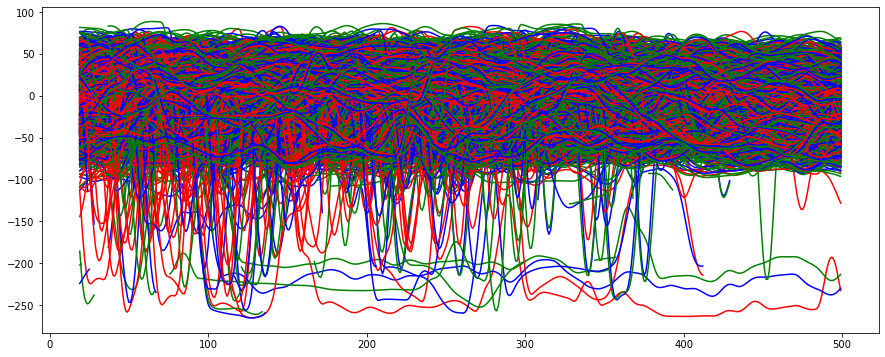

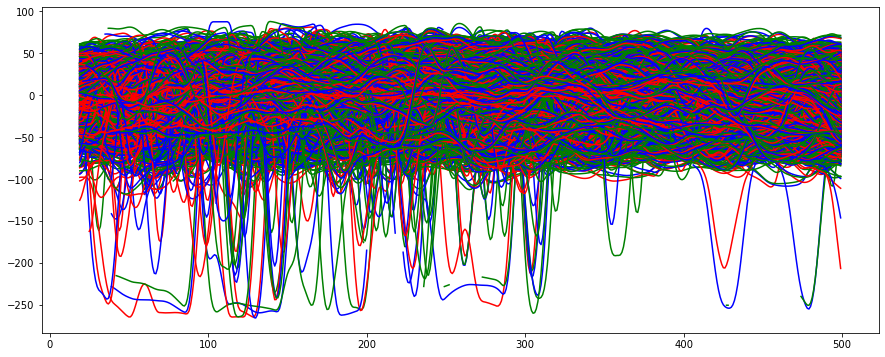

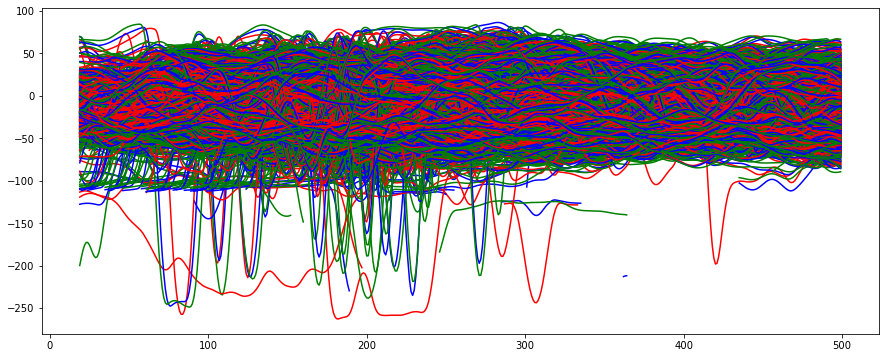

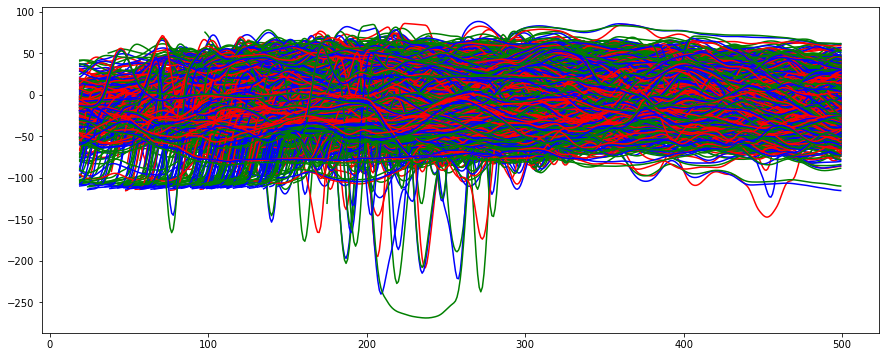

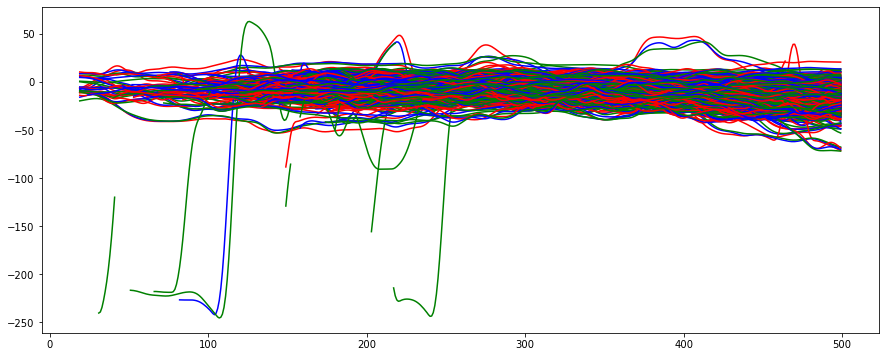

In [46]:
### Organize all data into python dict
from collections import defaultdict

search_key_path = ['*4mm*', '*_5mm*', '*8mm*', '*10mm*', '*45mm*']#'*15mm*', '*45mm*'] #I added _ to 5mm to distinguish it from 15,45
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']#'15mm', '45mm']

dict_ridge_all = defaultdict(dict)
for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
    data_location = "Z://UusisaariU//PROCESSED_DATA_BACKUPS//nRIM_MEMBERS//Salvo//RD_all_cond//RD_all_cond_analyzed//"
    RidgeX_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Ridge_X//*.csv'))
    TA_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'side_cam//*//*.csv'))
    TA_TopCam_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'top_cam//*//*.csv'))
    Centroid_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Centroid_XY//*.csv'))
    BodyAxis_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'BodyAxis//*.csv'))
    CentDistMid_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Cent_dst_to_mdline//*.csv'))
    BodyAxisHeadTail_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'BodyAxis_HeadTail//*.csv'))

    for i in np.arange(len(RidgeX_ExcelList_to_open)): # len(peaks)
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
        key_file_name = os.path.basename(RidgeX_ExcelList_to_open[i])
#        ax1.set_title(key_file_name)
#         print(key_file_name)
        #Extract arrays
        RidgeX_traj = RidgeX_excel_to_array_preprocessed(RidgeX_ExcelList_to_open, chunk_width, i)
        CentroidX_traj, CentroidY_traj = extract_Centroid(Centroid_ExcelList_to_open, chunk_width, i)
        BodyAxis_traj = RidgeX_excel_to_array_preprocessed(BodyAxis_ExcelList_to_open, chunk_width, i)
        CentMidline_traj = RidgeX_excel_to_array_preprocessed(CentDistMid_ExcelList_to_open, chunk_width, i)
        #Extract traces of Centroid and Tail Angle around the time frame when the mouse centroid is at the ridge center
        #a = firstNonNan(CentroidX_traj)
        #b = round((np.size(CentroidX_traj) - np.count_nonzero(np.isnan(CentroidX_traj)))/2)
        c = return_idx_long_nonNan_array(CentroidX_traj)
        #c = a + b

        #Take tail angle traj after extracting chunk of traj of interest around c
        TailAngle_traj = plot_TailAngle(TA_ExcelList_to_open, chunk_width, i, c)
        TailAngle_trajTC_1, TailAngle_trajTC_2, TailAngle_trajTC_3 = plot_TailAngleTC(TA_TopCam_ExcelList_to_open, chunk_width, i, c)
        
        #Take angle btw centroid and rear from topcam extraction
        BodyAxis_new_traj, Rear_X, Rear_Y, \
        Head_X, Head_Y = BodyAxis_HeadTail_excel_to_array_preprocessed(BodyAxisHeadTail_ExcelList_to_open, chunk_width, i)
        #print(BodyAxis_new_traj)
        TA_1_topcam_XY, TA_2_topcam_XY, TA_3_topcam_XY = extract_TailAngleTC_XY(TA_TopCam_ExcelList_to_open, chunk_width, i, c)
        Nose_topcam_XY = extract_NoseAngleTC_XY(TA_TopCam_ExcelList_to_open, chunk_width, i, c)
        Cent_XY = np.array([CentroidX_traj, CentroidY_traj])
        Head_XY = np.array([Head_X, Head_Y])
        Rear_XY = np.array([Rear_X, Rear_Y])
#         Angle_Cent_Rear = angle2pt_cent_TA(Rear_XY, Cent_XY)
#         #Take angle btw centroid and head from topcam extraction
#         #Nose_topcam_XY = extract_NoseAngleTC_XY(TA_TopCam_ExcelList_to_open, chunk_width, i, c)
#         Angle_Cent_Head = angle2pt_cent_TA(Head_XY, Cent_XY)
#         #Take angle btw centroid and tail base 1 and tail 2
#         Angle_Cent_Tail1_Tail2 = angle3pt_cent_TA(TA_2_topcam_XY, TA_1_topcam_XY, Cent_XY)#(Cent_XY, TA_1_topcam_XY, TA_2_topcam_XY)
#         #Take angle btw nose and tail base 1
#         #Angle_Nose_Tail1 = angle2pt_Tail_Nose(Nose_topcam_XY, TA_1_topcam_XY)#(Cent_XY, TA_1_topcam_XY, TA_2_topcam_XY)
        Angle_Cent_TailBase = angle2pt_cent_TA(TA_1_topcam_XY, Cent_XY)
        #Take angle btw centroid and nose from topcam extraction
        Angle_Cent_Nose = angle2pt_cent_TA(Nose_topcam_XY, Cent_XY)
        #Take angle btw centroid and tail base 1 and tail 2
        Angle_Cent_Tail1_Tail2 = angle3pt_cent_TA(TA_2_topcam_XY, TA_1_topcam_XY, Cent_XY)
        #Take angle btw nose and tail base 1
        Angle_Nose_Tail1 = angle2pt_Tail_Nose(Nose_topcam_XY, TA_1_topcam_XY)
        #Take angle btw nose cent and tail base 1 
        Angle_Nose_Cent_Tail1 = angle3pt_nose_cent_tail(TA_1_topcam_XY, Cent_XY, Nose_topcam_XY)
        

        
#         #Get chunk of traces
        RidgeX_traj_chunk = RidgeX_traj[c-chunk_width:c+chunk_width]
        TailAngle_traj_chunk = TailAngle_traj[c-chunk_width:c+chunk_width]
        TailAngle_trajTC_1_chunk = TailAngle_trajTC_1[c-chunk_width:c+chunk_width]
        TailAngle_trajTC_2_chunk = TailAngle_trajTC_2[c-chunk_width:c+chunk_width]
        TailAngle_trajTC_3_chunk = TailAngle_trajTC_3[c-chunk_width:c+chunk_width]
        Angle_Cent_TailBase_chunk = Angle_Cent_TailBase[c-chunk_width:c+chunk_width]
        Angle_Cent_Nose_chunk = Angle_Cent_Nose[c-chunk_width:c+chunk_width]
        Angle_Cent_Tail1_Tail2_chunk = Angle_Cent_Tail1_Tail2[c-chunk_width:c+chunk_width]
        Angle_Nose_Cent_Tail1_chunk = Angle_Nose_Cent_Tail1[c-chunk_width:c+chunk_width]
        Angle_Nose_Tail1_chunk = Angle_Nose_Tail1[c-chunk_width:c+chunk_width]
        

         #TailAngle_traj_chunk_corrected = check_trace(TailAngle_traj_chunk)
        CentroidX_traj_chunk = (CentroidX_traj[c-chunk_width:c+chunk_width])
        CentroidY_traj_chunk = (CentroidY_traj[c-chunk_width:c+chunk_width])
        BodyAxis_traj_chunk = BodyAxis_traj[c-chunk_width:c+chunk_width]
        BodyAxis_new_traj_chunk = BodyAxis_new_traj[c-chunk_width:c+chunk_width]
        CentMidline_traj_chunk = (CentMidline_traj[c-chunk_width:c+chunk_width])
        HipAngle_traj = plot_HipAngle(TA_ExcelList_to_open, chunk_width, i)
        HipAngle_traj_chunk = HipAngle_traj[c-chunk_width:c+chunk_width]

         #Compute R and L step 
        [RPAngle_traj, RP_x, LP_x]   = plot_RPAngle(TA_ExcelList_to_open, chunk_width, i)
        RP_x = RP_x[c-chunk_width:c+chunk_width]
        LP_x = LP_x[c-chunk_width:c+chunk_width]   
        RPAngle_traj_chunk = fill_nan(RPAngle_traj[c-chunk_width:c+chunk_width])

        #divide trial into step-based chunks RIGHT
        x_r = RP_x-np.nanmean(RP_x)
        x_l = LP_x-np.nanmean(LP_x)
        x_r_diff = np.diff(RP_x-np.nanmean(RP_x))
        x_l_diff = np.diff(-(LP_x-np.nanmean(-LP_x)))
        y_r = TailAngle_trajTC_1_chunk#-np.nanmean(TailAngle_traj)
        y_l = TailAngle_trajTC_1_chunk#-np.nanmean(TailAngle_traj)
        w = CentroidY_traj_chunk#-np.nanmean(Centroid_DIST_traj)#*50
        z = HipAngle_traj_chunk#-np.nanmean(HipAngle_traj)
        t = RPAngle_traj_chunk#-np.nanmean(RPAngle_traj)
        ba = BodyAxis_new_traj#BodyAxis_traj_chunk
        w_x = CentroidX_traj_chunk
        w_dist = CentMidline_traj_chunk
        step_chunk_R, TA_chunk_R, HA_chunk_R, cent_chunk_R, cent_chunk_XR, StepAngle_chunk_R, step_chunk_L_wrt_Rstep, \
         ba_wrt_Rstep, w_dist_Rstep = findpeaks_extractchunk(x_r_diff, x_r, y_r, z, w, w_x, t, x_l, ba, w_dist, 0.9, chunk_width//2)

        #divide trial into step-based chunks LEFT
        step_chunk_L, TA_chunk_L, HA_chunk_L, cent_chunk_L, cent_chunk_XL, StepAngle_chunk_L, step_chunk_R_wrt_Lstep, \
         ba_wrt_Lstep, w_dist_Lstep = findpeaks_extractchunk(x_l_diff, x_l, y_l, z, w, w_x, t, x_r, ba, w_dist, 0.9, chunk_width//2)


        #Decide here what variables to plot in the three figures
        var1 = np.array(RidgeX_traj_chunk)
        var2 = np.array(TailAngle_trajTC_1_chunk)# TailAngle_traj_chunk
        var3 = np.array(CentroidX_traj_chunk) 
        var4 = step_chunk_R
        var5 = TA_chunk_R
        var6 = step_chunk_L
        var7 = TA_chunk_L
        var8 = StepAngle_chunk_R
        var9 = StepAngle_chunk_L
        var10 = cent_chunk_R #CentY
        var11 = cent_chunk_L #CentY
        var12 = cent_chunk_XR
        var13 = HA_chunk_R
        var14 = StepAngle_chunk_R
        var15 = step_chunk_L_wrt_Rstep
        var16 = ba_wrt_Rstep
        var17 = ba_wrt_Lstep
        var18 = HA_chunk_L
        var19 = np.array(BodyAxis_new_traj_chunk)##BodyAxis_traj_chunk)
        var20 = w_dist_Lstep
        var21 = w_dist_Rstep
        var22 = CentroidY_traj_chunk
        var23 = CentMidline_traj_chunk
        var24 = Angle_Cent_TailBase_chunk
        var25 = Angle_Cent_Nose_chunk
        var26 = Angle_Cent_Tail1_Tail2_chunk
        var27 = BodyAxis_traj_chunk
        var28 = Angle_Nose_Tail1_chunk
        var29 = Angle_Nose_Cent_Tail1_chunk
        var30 = HipAngle_traj_chunk
        var31 = np.array(TailAngle_trajTC_2_chunk)
        var32 = np.array(TailAngle_trajTC_3_chunk)


#         #Make dict
        key_file_name = os.path.basename(RidgeX_ExcelList_to_open[i])
# #         print(key_file_name)
        dict_ridge_all[search_key[j]][key_file_name] = [var1, var2, var3, var4, var5, var6, var7, \
                                                         var8, var9, var10, var11, var12, var13, var14, var15, \
                                                         var16, var17, var18, var19, var20, var21, var22, var23, \
                                                         var24, var25, var26, var27, var28, var29, var30, var31, var32]

#       Plot traces
        #print(var19)
        ax1.plot(var2, color = 'red')#-np.nanmean(Angle_Cent_TailBaseTopCam), color = 'red')
        ax1.plot(var31, color = 'blue')
        ax1.plot(var32, color = 'green')

# #         bla = [i[0] for i in TA_1_topcam_XY]
# #         ax1.plot(bla-np.nanmean(bla), color = 'blue')
# #         ax1.plot(Cent_XY[0]-np.nanmean(Cent_XY[0]), color = 'green')

#         ax1.set_title(key_file_name)
#         print(var5)
#         for s in np.arange(len(var5)):
#             if len(var5):
#                 fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
#                 ax1.plot(var5[s], color = 'red')
   

In [ ]:
# def assign_dict_value_ridge_pos(dict_ridge):
#     #Divide trials based on ridge position. Assign -1 for left tilt, +1 for right and 0 for no tilts. Append to 4th col
#     #Changed the threshold from 5000 to 10000 bcs M53 detected many no pert trials as pert
#     key_list = list(dict_ridge.keys())

#     for i in np.arange(len(key_list)):

#         ridge_array = dict_ridge[key_list[i]][0]
#         ridge_array_translated_nonNaN = ridge_array[~np.isnan(ridge_array)]
#         ridge_array_translated_nonNaN_mean_centered = ridge_array_translated_nonNaN-  \
#         np.nanmean(smooth(ridge_array_translated_nonNaN[20:40]))
#         ridge_array_translated_int = np.trapz(smooth(ridge_array_translated_nonNaN_mean_centered, 50))
#         ridge_array_translated_nonNaN_mean_centered_diff_max = max(np.diff(ridge_array_translated_nonNaN_mean_centered))
#         if ridge_array_translated_int < -3000 and ridge_array_translated_nonNaN_mean_centered_diff_max<40:
#             dict_ridge[key_list[i]].append(-1)
#             #print(ridge_array_translated_nonNaN_mean_centered_diff_max)
#         elif ridge_array_translated_int > +3000 and ridge_array_translated_nonNaN_mean_centered_diff_max<40:
#             dict_ridge[key_list[i]].append(1)
#     #        print(ridge_array_translated_int)

#         else:
#             dict_ridge[key_list[i]].append(0)    
    
#     return dict_ridge

In [ ]:
# def eliminate_pert_trials_from_dict(dict_ridge):
#     values_list = list(dict_ridge.values())
#     key_list = list(dict_ridge.keys())
#     for i in np.arange(len(key_list)):
#         Ridge_classvalue = values_list[i][-1]
#         if Ridge_classvalue == 1 or Ridge_classvalue == -1:
#             key_to_be_deleted = key_list[i]
#             dict_ridge.pop(key_to_be_deleted, None)    
#     return dict_ridge

In [ ]:
def excludeNaNTATraces(dict_ridge):
    #Exclude from dict all trials where the TA traj is mostly NaN
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):
        TA_traj = values_list[i][1]
        no_of_nan_TAtraj = list(np.isnan(TA_traj))
        count_NaN = no_of_nan_TAtraj.count(1)
        if count_NaN>70:
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)
        elif len(TA_traj) == 0:
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)    
    return dict_ridge      

In [ ]:
def transpose_traces_0_360_range(dict_ridge):
    #Transpose from dict all trials where the TA traj is outsude [0, 360] and append to 13th column 
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())
    #dict_TA_transpose = {}
    for i in np.arange(len(key_list)):
        TA_traj = values_list[i][4]
        key_to_change = key_list[i]
        TA_to_append = []
        for j in np.arange(len(TA_traj)):
            if np.nanmean(TA_traj[j])>400:
                TA_traj_pushed_down = TA_traj[j]-360
                TA_to_append.append(TA_traj_pushed_down)      
            elif np.nanmean(TA_traj[j])<-100:
                TA_traj_pushed_up = TA_traj[j]+360
                TA_to_append.append(TA_traj_pushed_up)
            else:
                TA_to_append.append(TA_traj[j])
        dict_ridge[key_to_change].append(TA_to_append)    

    return dict_ridge

In [ ]:
def excludeTATracesNON_0_360(dict_ridge):
    #Exclude from dict all trials where the TA traj is outside 0 to 360 
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_traj = values_list[i][4]
        for j in np.arange(len(TA_traj)):
            #print(len(TA_traj))
            if np.nanmean(TA_traj[j])>350:
                TA_traj[j] = []
            elif np.nanmean(TA_traj[j]) < 10:
                TA_traj[j] = []
    return dict_ridge   

In [ ]:
def excludeTATracesHighDerivative(dict_ridge):
    #Exclude from dict all trials where the TA traj derivative is high
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_traj = values_list[i][4]
        for j in np.arange(len(TA_traj)): # step
            TA_diff = np.diff(TA_traj[j])
            if np.any(TA_diff>8) or np.any(TA_diff<-8):
                TA_traj[j] = []
    return dict_ridge   

In [ ]:
def transpose_TA_ipsi_contra_within0_360_range(TA_traj):
    if np.nanmean(TA_traj)>400:
        TA_traj = TA_traj-360
    elif np.nanmean(TA_traj)<-40:
        TA_traj = TA_traj+360
    return TA_traj

In [ ]:
def decide_TA_traj_wrt_IpsiorContraStep(TA_traj_listwrtR, TA_traj_listwrtL):
    TA_wrtIpsiStep = []
    TA_wrtContraStep = []
    if np.nanmean(TA_traj_listwrtR[110:130]) < 180:
        TA_wrtIpsiStep = TA_traj_listwrtR
    if np.nanmean(TA_traj_listwrtL[110:130]) > 180:
        TA_wrtIpsiStep = -TA_traj_listwrtL+360
    if np.nanmean(TA_traj_listwrtR[110:130]) > 180:
        TA_wrtContraStep = -TA_traj_listwrtR+360
    if np.nanmean(TA_traj_listwrtL[110:130]) < 180:
        TA_wrtContraStep = TA_traj_listwrtL
    return TA_wrtIpsiStep, TA_wrtContraStep

In [ ]:
def decide_HA_traj_wrt_IpsiorContraStep(TA_traj_listwrtR, TA_traj_listwrtL, Hip_traj_list_wrt_R, Hip_traj_list_wrt_L):
    Hip_wrtIpsiStep = []
    Hip_wrtContraStep = []
    if np.nanmean(TA_traj_listwrtR[110:130]) < 180:
        Hip_wrtIpsiStep = Hip_traj_list_wrt_R
    if np.nanmean(TA_traj_listwrtL[110:130]) > 180:
        Hip_wrtIpsiStep = -Hip_traj_list_wrt_L+360+180
    if np.nanmean(TA_traj_listwrtR[110:130]) > 180:
        Hip_wrtContraStep = -Hip_traj_list_wrt_R+360+180
    if np.nanmean(TA_traj_listwrtL[110:130]) < 180:
        Hip_wrtContraStep = Hip_traj_list_wrt_L
    return Hip_wrtIpsiStep, Hip_wrtContraStep

In [ ]:
def transposeBA(BA):
    BA = [abs(abs(element)-90) for element in BA]
    BA = [el for el in BA if el<20]
    BA = np.array(BA)
    return BA

In [ ]:
def excludeemptyarray(dict_ridge):
    #Exclude from dict all trials where the TA traj derivative is high and return to COL 15
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_traj_listwrtR = values_list[i][4]
        TA_traj_listwrtL = values_list[i][6]
        COM_traj_list = values_list[i][9]
        COMX_traj_list = values_list[i][11]
        Hip_traj_list_wrt_R = values_list[i][12]
        Hip_traj_list_wrt_L = values_list[i][17]
        StepAnlge_traj_list = values_list[i][13]
        ContraStep_traj_list = values_list[i][14]
        Step_x_traj_list = values_list[i][3]
        BA_traj_wrtR = values_list[i][16]
        cent_dist_traj_wrtR = values_list[i][20]
        values_to_append = []
        for j, k in zip(np.arange(len(TA_traj_listwrtR)), np.arange(len(TA_traj_listwrtL))):
            if len(TA_traj_listwrtR[j]) and len(COM_traj_list[j]):
                #Transpose traces beyond 0-360 and exclude traces that are still beyon range
                TA_traj_listwrtL_T = transpose_TA_ipsi_contra_within0_360_range(TA_traj_listwrtL[k])
                TA_traj_listwrtR_T = transpose_TA_ipsi_contra_within0_360_range(TA_traj_listwrtR[j])
                Hip_traj_transpose = transpose_TA_ipsi_contra_within0_360_range(Hip_traj_list_wrt_R[j])####
                Hip_traj_transpose = transpose_TA_ipsi_contra_within0_360_range(Hip_traj_transpose)####
                #divide TA traces based on contra step
                TA_wrtIpsiStep, TA_wrtContraStep = decide_TA_traj_wrt_IpsiorContraStep(TA_traj_listwrtR_T, \
                                                                                       TA_traj_listwrtL_T)
                HA_wrtIpsiStep, HA_wrtContraStep = decide_HA_traj_wrt_IpsiorContraStep(TA_traj_listwrtR_T, \
                                                                                       TA_traj_listwrtL_T, \
                                                                                       Hip_traj_list_wrt_R[j], \
                                                                                       Hip_traj_list_wrt_L[k])
                #Transpose BA R so that there is no jump to -90
                BA_tracesR = transposeBA(BA_traj_wrtR[j])
                #Compute angle of tail from top cam
                new_alpha = TA_traj_listwrtR[j]%(360)

                if np.nanmean(new_alpha) > 200:
                    new_alpha = abs(new_alpha -360)
                else:
                    new_alpha = abs(new_alpha)
                if len(BA_tracesR) ==250 and all(BA_tracesR<20):
                    BA_tracesR_mean = np.nanmean(BA_tracesR[75:175])
                else:
                    BA_tracesR_mean = []
                TA_topcam = new_alpha
                TA_topcam_mean = np.nanmean(TA_topcam)
                #Assign to value in dict
                values_to_append.append([TA_topcam, TA_traj_listwrtR[j], COM_traj_list[j], COMX_traj_list[j], \
                                         Hip_traj_list_wrt_R[j], StepAnlge_traj_list[j],\
                                         Step_x_traj_list[j], StepAnlge_traj_list[j], TA_wrtContraStep, \
                                         TA_wrtIpsiStep, TA_traj_listwrtL[k], ContraStep_traj_list[j], \
                                         Hip_traj_list_wrt_L[k], HA_wrtIpsiStep, HA_wrtContraStep, TA_topcam_mean, \
                                         TA_topcam, BA_tracesR, BA_tracesR_mean, cent_dist_traj_wrtR[j], Hip_traj_transpose])
        dict_ridge[key_list[i]].append(values_to_append)
    return dict_ridge 

In [ ]:
def firstNonNan(listfloats):
    i = 0
    for item in listfloats:
        i += 1
        if math.isnan(item) == False:
            return i

In [ ]:
#write function to compute speed of COM
def return_COM_speed(dict_ridge):
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        #print(values_list[14][-1])

        COM_traj_list = values_list[i][-1]# last value in dict with COM empty array excluded
        COM_to_append = []
        for j in np.arange(len(COM_traj_list)):
            COM_traj = COM_traj_list[j][1]
            Centroid_DIST_traj_subtract1stelement = COM_traj-COM_traj[0]
            Centr_vel = (Centroid_DIST_traj_subtract1stelement[-1])/np.size(COM_traj)
            Centr_vel_pixelPersecond = Centr_vel *300 #300 Hz frames
            COM_to_append.append(Centr_vel_pixelPersecond)
        dict_ridge[key_list[i]].append(COM_to_append)  
    return dict_ridge   

In [ ]:
#write function to compute speed of COM
def return_TA_integral_Rstep(dict_ridge):
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_traj_list = values_list[i][-2]# last value in dict with TA empty array excluded
        #print(TA_traj_list)
        TA_to_append = []
        for j in np.arange(len(TA_traj_list)):
            TA_traj = TA_traj_list[j][0]
            TA_traj_diff = np.diff(TA_traj)
            TA_traj_integral = np.trapz(TA_traj_diff[120:150])
            TA_to_append.append(TA_traj_integral)
        dict_ridge[key_list[i]].append(TA_to_append)  
    return dict_ridge  

In [ ]:
def append_zero_to_dict(dict_ridge):
    key_list = list(dict_ridge.keys())
    for i in np.arange(len(key_list)):
        ridge_array = dict_ridge[key_list[i]][0]
        dict_ridge[key_list[i]].append(0)    
    return dict_ridge

In [ ]:
#Write script to pre-process and organize all pert trial into python dict

search_key = ['4mm', '5mm', '8mm', '10mm', '15mm', '45mm']

dict_preprocessed_all = defaultdict(dict)

for i in np.arange(len(search_key)):
    if i < 4:
        dict_ridge = dict_ridge_all[search_key[i]]
        dict_ridge_ridge_pos = assign_dict_value_ridge_pos(dict_ridge)
        dict_ridge_el_pert_trial = eliminate_pert_trials_from_dict(dict_ridge_ridge_pos)
        dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = excludeemptyarray(dict_ridge_el_pert_trial)#dict_TA_transpose_btw_0_360)
        dict_preprocessed_all[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array
    elif i >3:
        dict_ridge = dict_ridge_all[search_key[i]]
        dict_ridge = append_zero_to_dict(dict_ridge) #to match size with dictionary element in the loop above
        dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = excludeemptyarray(dict_ridge)#dict_TA_transpose_btw_0_360)
        dict_preprocessed_all[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array

In [ ]:
def excludeTA_outrange(TA):
    if any(i < -30 or i > 250 for i in TA):
        TA = []
    return TA

In [ ]:
def return_Mean_STD_forPSTH(array_value_dict):
    mean_array = np.nanmean(array_value_dict, axis = 0)
    STD_array = stats.sem(array_value_dict, nan_policy='omit')
    return mean_array, STD_array

In [ ]:
#### PLOT top camera tail angle and compute mean
MouseID_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '15mm', '45mm']
dict_TA_topcam_mean = defaultdict(dict)


for k in np.arange(len(search_key)):    
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    dict_ridge_Xwidth = dict_preprocessed_all[search_key[k]]
    values_list = list(dict_ridge_Xwidth.values())
    key_list = list(dict_ridge_Xwidth.keys()) 
    TA_topcam_mean_list = []
    for i in np.arange(len(key_list)):
        #print(len(values_list[i]))
        TA_traj_wrt_step = values_list[i][-1] #no of last attached array of values
        for j in np.arange(len(TA_traj_wrt_step)):
            plt.plot(TA_traj_wrt_step[j][16]) #no corresponding to top cam TA angle trace
            TA_topcam_mean_list.append(TA_traj_wrt_step[j][15]) #no corresponding to top cam TA angle mean
    dict_TA_topcam_mean[search_key[k]] = TA_topcam_mean_list

In [ ]:
#Compute first nonNaN value of array
def firstNonNan(listfloats):
    for item in listfloats:
        if math.isnan(item) == False:
            return item

In [ ]:
#Plot and compute distance of Centroid X from edges of ridge
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
threshold_comx = [10, 10, 10, 12, 30]
dist_from_edge = [2, 2.5, 4, 5, 22.5]
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
dict_cent_dist = defaultdict(dict)

for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    bla = dict_ridge_all[search_key[j]]
    values_list = list(bla.values())
    key_list = list(bla.keys())
    cent_dist_list = []
    for i in np.arange(len(key_list)-1):
        cent_dist_traj = values_list[i][22]
        cent_dist_traj_nonNaN = cent_dist_traj[np.logical_not(numpy.isnan(cent_dist_traj))]
        if all(cent_dist_traj_nonNaN < threshold_comx[j]):
            #Compute distance from ridge edge, with neg outside of edge
            cent_dist_from_edge_traj = -(cent_dist_traj*scaling_pixels[j])+dist_from_edge[j]
            plt.plot(cent_dist_from_edge_traj)
            cent_dist_list.append(np.nanmean(cent_dist_from_edge_traj))
    dict_cent_dist[search_key[j]] = cent_dist_list
    #plt.ylim(-5, 5)

In [ ]:
#Plot forward velocity and insert value in dict
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
dict_vel = defaultdict(dict)

for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    bla = dict_ridge_all[search_key[j]]
    values_list = list(bla.values())
    key_list = list(bla.keys())
    vel_list = []
    for i in np.arange(len(key_list)-1):
        comy_traj = values_list[i][21]
        comy_traj_nonNaN = comy_traj[np.logical_not(numpy.isnan(comy_traj))]
        if all(np.diff(comy_traj_nonNaN)>0):
            comy_traj_seg = comy_traj_nonNaN
            #Compute first and last nonNan value from CentY and velocity
            centY_nonNan_first = comy_traj_seg[0]
            centY_nonNan_last = comy_traj_seg[-1]
            vel_centY = ((centY_nonNan_last-centY_nonNan_first)*scaling_pixels[j])/(((len(comy_traj_seg))*(1/300))*1000)#scaling m/s
            plt.plot(comy_traj_seg)#-centY_nonNan)
            #Take avg of 1st and last segments of Centroid trace and compute differences of idx 
            vel_list.append(vel_centY)
    dict_vel[search_key[j]] = vel_list

In [ ]:
#Plot CentroidX and compute average distance from midline
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
scaling_factor = [4, 5, 8, 10, 45] #divide by this number to get relative distance from midline

dict_CentX = defaultdict(dict)

for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    bla = dict_ridge_all[search_key[j]]
    values_list = list(bla.values())
    key_list = list(bla.keys())
    CentX_traj_list = []
    for i in np.arange(len(key_list)-1):
        CentX_traj = (smooth(values_list[i][22], 10))*scaling_pixels[j] #Given that movement of interes is around 30 ms I take a smooth window of 10
        CentX_traj_rel = abs(np.diff(CentX_traj/scaling_factor[j]))
        CentX_traj_vel_metpersec = CentX_traj_rel*(300)
        CentX_traj_nonNaN = CentX_traj[np.logical_not(numpy.isnan(CentX_traj))]
        if j <5 and all(CentX_traj_nonNaN<10):
            plt.plot(CentX_traj_vel_metpersec)
            CentX_traj_list.append(np.nanmean(CentX_traj_vel_metpersec))
        elif j ==5:
            plt.plot(CentX_traj_vel_metpersec)
            CentX_traj_list.append(np.nanmean(CentX_traj_vel_metpersec))
    #plt.ylim(-10, 10)
    dict_CentX[search_key[j]] = CentX_traj_list

In [ ]:
#Plot distance from midline and compute average velocity of distance from midline 
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
scaling_factor = [2, 2.5, 4, 5, 22.5] #divide by this number to get relative distance from midline

dict_CentX = defaultdict(dict)

for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    bla = dict_ridge_all[search_key[j]]
    values_list = list(bla.values())
    key_list = list(bla.keys())
    CentX_traj_list = []
    for i in np.arange(len(key_list)-1):
        CentX_traj = ((smooth(values_list[i][22], 10))*scaling_pixels[j])#Convert to mm
        CentX_traj_rel = abs(np.diff(CentX_traj/scaling_factor[j]))
        CentX_traj_vel_metpersec = CentX_traj_rel/(1/300) #convert to mm/s
        CentX_traj_nonNaN = CentX_traj[np.logical_not(numpy.isnan(CentX_traj))]
        if j <5 and all(CentX_traj_nonNaN<10):
            plt.plot(CentX_traj_rel)
            CentX_traj_list.append(np.nanmean(CentX_traj_vel_metpersec))
        elif j == 5:
            plt.plot(CentX_traj_rel)
            CentX_traj_list.append(np.nanmean(CentX_traj_vel_metpersec))
    #plt.ylim(-10, 30)
    dict_CentX[search_key[j]] = CentX_traj_list

In [ ]:
#Plot CentroidX and compute average velocity of CentroidX (horizontal sway)
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
scaling_factor = [2, 2.5, 4, 5, 22.5] #divide by this number to get relative distance from midline

dict_CentX = defaultdict(dict)

for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    bla = dict_ridge_all[search_key[j]]
    values_list = list(bla.values())
    key_list = list(bla.keys())
    CentX_traj_list = []
    for i in np.arange(len(key_list)-1):
        CentX_traj = (smooth(values_list[i][2], 10))*scaling_pixels[j]#Convert to mm
        CentX_traj_rel = np.diff(CentX_traj/scaling_factor[j])
        CentX_traj_vel_metpersec = CentX_traj_rel/(1/300) #convert to mm/s
        CentX_traj_vel_metpersec_nonNaN = CentX_traj_vel_metpersec[np.logical_not(numpy.isnan(CentX_traj_vel_metpersec))]
        if j <4 and all(CentX_traj_vel_metpersec_nonNaN <35) and all(CentX_traj_vel_metpersec_nonNaN >-40):
            plt.plot(CentX_traj_vel_metpersec)
            CentX_traj_list.append(np.nanmean(CentX_traj_vel_metpersec_nonNaN))
        elif j == 4:
            plt.plot(CentX_traj_vel_metpersec)
            CentX_traj_list.append(np.nanmean(CentX_traj_vel_metpersec_nonNaN))
    #plt.ylim(-0.5, 0.5)
    dict_CentX[search_key[j]] = CentX_traj_list

In [ ]:
#Count no of trials mice COM goes outside of the ridge
search_key = ['4mm', '5mm', '8mm', '10mm']#, '45mm']
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
scaling_factor = [2, 2.5, 4, 5] #divide by this number to get relative distance from midline
clrs = sns.color_palette("husl", 4)

dict_CentX = defaultdict(dict)
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for j in np.arange(len(search_key)):
    #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    bla = dict_ridge_all[search_key[j]]
    values_list = list(bla.values())
    key_list = list(bla.keys())
    CentX_traj_list = []
    a = 0
    for i in np.arange(len(key_list)-1):
        CentX_traj = (smooth(values_list[i][22], 10))*scaling_pixels[j] #Given that movement of interes is around 30 ms I take a smooth window of 10
        CentX_traj_rel = CentX_traj/scaling_factor[j]
        CentX_traj_vel_metpersec = CentX_traj_rel#*(300)
        CentX_traj_nonNaN = CentX_traj[np.logical_not(numpy.isnan(CentX_traj))]
        if j <5 and all(CentX_traj_nonNaN<6):# and len(CentX_traj_vel_metpersec) == 509:
            plt.plot(CentX_traj_vel_metpersec, c = clrs[j], lw=0.3, alpha = 0.8)
            count_outCOM = np.where(CentX_traj_vel_metpersec > 1, 1, 0)
            sum_count_outCOM = np.sum(count_outCOM)
            perc_time_p_outCOM = sum_count_outCOM/500
            if sum_count_outCOM>10:
                a = a+1
#            non_nan_array = CentX_traj_vel_metpersec[~np.isnan(CentX_traj_vel_metpersec)]
#             if len(non_nan_array[100:400]) == 300:
#                 CentX_traj_list.append(non_nan_array[100:400])
#         elif j ==5:
#             plt.plot(CentX_traj_vel_metpersec)
#             CentX_traj_list.append(CentX_traj_vel_metpersec)
    print(a)
    plt.ylim(-1, 3)
    dict_CentX[search_key[j]] = CentX_traj_list

In [ ]:
#Count % of trials mice COM goes outside of the ridge divided by Mouse ID
search_key = ['4mm']#, '5mm', '8mm', '10mm']#, '45mm']
MouseID_key = ['M58']#'M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58']#, 'M59', 'M60', 'M61', 'M62']

ridge_half_widths = [2.5, 3, 5, 6]
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
clrs = sns.color_palette("husl", 4)

dict_perc_time_p_outCOM = defaultdict(dict)
#fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    perc_time_p_outCOM_listMouseID = []
    for k in np.arange(len(MouseID_key)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_ridge_all[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        perc_time_p_outCOM_list = []
        a = 0
        for i in np.arange(len(key_list)-1):
            CentX_traj = values_list[i][22] #Given that movement of interes is around 30 ms I take a smooth window of 10
            CentX_traj_nonNaN = CentX_traj[np.logical_not(numpy.isnan(CentX_traj))]
            if j <5 and all(CentX_traj_nonNaN<6):# and len(CentX_traj_vel_metpersec) == 509:
                plt.plot(CentX_traj, c = clrs[j])#, lw=0.3, alpha = 0.8)
                #Count frames where COM is beyond ridge distance
                count_outCOM = np.where(CentX_traj > ridge_half_widths[j], 1, 0)
                sum_count_outCOM = np.sum(count_outCOM)
                print(key_list[i])
                perc_time_p_outCOM = sum_count_outCOM/500
                perc_time_p_outCOM_list.append(perc_time_p_outCOM)
        perc_time_p_outCOM_listMouseID.append(np.nanmean(perc_time_p_outCOM_list))
    dict_perc_time_p_outCOM[search_key[j]] = perc_time_p_outCOM_listMouseID
    #plt.ylim(-1, 3)

In [ ]:
dict_perc_time_p_outCOM

In [ ]:
##Add entire trial trace of tail angle from top camera divided by Mouse ID in dictionary
def extractTAtopcam(dict_ridge):
    #Exclude from dict all trials where the TA traj derivative is high and return to COL 15
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_topcam = values_list[i][1]
        values_to_append = []
        if len(TA_topcam):
            #exclude nan
            TA_topcam_nonNan = TA_topcam[~np.isnan(TA_topcam)]
#             #transpose angle of tail from top cam to 0-360 limit
#             TA_topcamT = np.unwrap((TA_topcam_nonNan)%(360))
            if np.nanmean(TA_topcam_nonNan) > 250:
                TA_topcam_nonNan = abs(TA_topcam_nonNan -360)
            else:
                TA_topcam_nonNan = abs(TA_topcam_nonNan)
            #Assign to value in dict
#             if all(TA_topcam_nonNan<110):
            values_to_append.append(TA_topcam_nonNan)
            plt.plot(values_to_append[0])
        dict_ridge[key_list[i]].append(values_to_append)
    return dict_ridge 

In [ ]:
#Compute dict with TAtopcam angle only of non pert trials

search_key = ['4mm', '5mm', '8mm', '10mm', '15mm', '45mm']

dict_preprocessed_all_TA_topcam = defaultdict(dict)

for i in np.arange(len(search_key)):
    if i < 4:
        fig, ax1 = plt.subplots(1, 1, figsize=(25,15))
        dict_ridge = dict_ridge_all[search_key[i]]
        dict_ridge_ridge_pos = assign_dict_value_ridge_pos(dict_ridge)
        dict_ridge_el_pert_trial = eliminate_pert_trials_from_dict(dict_ridge_ridge_pos)
        dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = extractTAtopcam(dict_ridge_el_pert_trial)#dict_TA_transpose_btw_0_360)
        dict_preprocessed_all_TA_topcam[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array
    elif i >3:
        fig, ax1 = plt.subplots(1, 1, figsize=(25,15))
        dict_ridge = dict_ridge_all[search_key[i]]
        dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = extractTAtopcam(dict_ridge)#dict_TA_transpose_btw_0_360)
        dict_preprocessed_all_TA_topcam[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array

In [ ]:
#### PLOT top camera tail angle and compute mean by Mouse ID of entire trial
MouseID_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
dict_TA_topcam_mean = defaultdict(dict)

#dict_TAtopcam = defaultdict(dict)
for j in np.arange(len(search_key)):
    mean_list_TA_topcam_MouseID = []
    for k in np.arange(len(MouseID_key)):
        fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_preprocessed_all_TA_topcam[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        TA_topcam_mean_list = []
        for i in np.arange(len(key_list)-1):
            TA_traj_topcam = values_list[i][-1][0] #no of last attached array of values
            if all(TA_traj_topcam<150):
                #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
                plt.plot(TA_traj_topcam)
                #compute peaks of trace
                interval_lowlim = 100
                interval_uplim = 400                
                peaks_idx, _ = find_peaks(TA_traj_topcam[interval_lowlim:interval_uplim], distance = 50)
                peaks_value = TA_traj_topcam[interval_lowlim+peaks_idx]
                #print(key_list[i])
                plt.plot(peaks_idx+interval_lowlim, peaks_value, 'x')
                TA_topcam_mean_list.append(max(peaks_value))#exclude first and last 100ms from mean
        mean_list_TA_topcam_MouseID.append(np.nanmean(TA_topcam_mean_list))
    dict_TA_topcam_mean[search_key[j]] = mean_list_TA_topcam_MouseID
    
 

In [ ]:
#Extract angle btw centroid and tail base from topcam

In [ ]:
#RESCUE THIS
# ##Add entire trial trace of angle btw centroid and tail base from top camera divided by Mouse ID in dictionary
# def extractCent_TailBase(dict_ridge):
#     values_list = list(dict_ridge.values())
#     key_list = list(dict_ridge.keys()) #trial
#     for i in np.arange(len(key_list)):
#         TA_topcam = values_list[i][23]#23
#         bla = values_list[i][22]
#         values_to_append = []
#         bla_nonNan = bla[~np.isnan(bla)]        
#         if len(TA_topcam) and all(bla_nonNan<150):
#             #exclude nan
#             TA_topcam_nonNan = TA_topcam[~np.isnan(TA_topcam)]
#             values_to_append.append(TA_topcam_nonNan)
#             #plt.plot(values_to_append[0])
#             plt.plot(bla)
#         #plt.ylim(-40,40)
#         dict_ridge[key_list[i]].append(values_to_append)
#     return dict_ridge 

In [ ]:
# AND NOT THIS
##Add entire trial trace of angle btw centroid and tail base from top camera divided by Mouse ID in dictionary
def extractCent_TailBase(dict_ridge):
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_topcam = values_list[i][25]#23
        bla = values_list[i][22]
        values_to_append = []
        bla_nonNan = bla[~np.isnan(bla)]        
        if len(TA_topcam):# and all(bla_nonNan<150):
            #exclude nan
            TA_topcam_nonNan = TA_topcam[~np.isnan(TA_topcam)]
            values_to_append.append(TA_topcam_nonNan)
            #plt.plot(values_to_append[0])
            plt.plot(TA_topcam_nonNan)
        #plt.ylim(-40,40)
        dict_ridge[key_list[i]].append(values_to_append)
    return dict_ridge 

In [ ]:
#Compute dict with angle btw centroid and tail base only of non pert trials

search_key = ['4mm', '5mm', '8mm', '10mm', '15mm', '45mm']

dict_preprocessed_all_TailBase = defaultdict(dict)

for i in np.arange(len(search_key)):
    if i < 4:
        fig, ax1 = plt.subplots(1, 1, figsize=(25,15))
        dict_ridge = dict_ridge_all[search_key[i]]
        dict_ridge_ridge_pos = assign_dict_value_ridge_pos(dict_ridge)
        dict_ridge_el_pert_trial = eliminate_pert_trials_from_dict(dict_ridge_ridge_pos)
        dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = extractCent_TailBase(dict_ridge_el_pert_trial)#dict_TA_transpose_btw_0_360)
        dict_preprocessed_all_TailBase[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array
    elif i >3:
        fig, ax1 = plt.subplots(1, 1, figsize=(25,15))
        dict_ridge = dict_ridge_all[search_key[i]]
        dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = extractCent_TailBase(dict_ridge)#dict_TA_transpose_btw_0_360)
        dict_preprocessed_all_TailBase[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array

In [ ]:
def compute_amlpit(vector):
    ampl = max(vector)# - min(vector)
    return ampl

In [ ]:
def extract_min_max_subtrace(vec):
    len_vec = len(vec)
    len_vec1 = int(len_vec/3)
    len_vec2 = int((len_vec/3)*2)
    vec1 = vec[0:len_vec1]
    vec2 = vec[len_vec1:len_vec2]
    vec3 = vec[len_vec2:len_vec]
    vec1_amp = compute_amlpit(vec1)
    vec2_amp = compute_amlpit(vec2)
    vec3_amp = compute_amlpit(vec3)
    mean_vecs = np.nanmean([vec1_amp, vec2_amp, vec3_amp])
    return mean_vecs

In [ ]:
####  Amplitude of angle btw centroid and tail base by Mouse ID of entire trial
MouseID_key = [ 'M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
dict_Cent_TailBase_mean = defaultdict(dict)

#dict_TAtopcam = defaultdict(dict)
for j in np.arange(len(search_key)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    mean_list_Cent_TailBase_MouseID = []
    for k in np.arange(len(MouseID_key)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_preprocessed_all_TailBase[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        Cent_TailBase_mean_list = []
        for i in np.arange(len(key_list)-1):
            Cent_TailBase_traj = values_list[i][-1][0] #no of last attached array of values
            bla = values_list[i][22]
            bla_nonNan = bla[~np.isnan(bla)]        
            if len(Cent_TailBase_traj)>150 and all(bla_nonNan<10):#all(TA_traj_topcam<70) and len(TA_traj_topcam)>250:
                Cent_TailBase_traj_abs = abs(Cent_TailBase_traj-180)#exclude first 30 frames, as the tail angle is not visible
                plt.plot(Cent_TailBase_traj_abs)#Cent_TailBase_traj_abs)#Cent_TailBase_traj_abs)
                Cent_TailBase_amp_means = extract_min_max_subtrace(Cent_TailBase_traj_abs)
                Cent_TailBase_mean_list.append(Cent_TailBase_amp_means)
        mean_list_Cent_TailBase_MouseID.append(np.nanmean(Cent_TailBase_mean_list))
    dict_Cent_TailBase_mean[search_key[j]] = mean_list_Cent_TailBase_MouseID
    
 

In [ ]:
dict_Cent_TailBase_mean

In [ ]:
## RESCUE THIS
# ####  Mean of angle btw centroid and tail base by Mouse ID of entire trial
# MouseID_key = ['M62']#'M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
# search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
# dict_Cent_TailBase_mean = defaultdict(dict)

# #dict_TAtopcam = defaultdict(dict)
# for j in np.arange(len(search_key)):
#     mean_list_Cent_TailBase_MouseID = []
#     fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
#     for k in np.arange(len(MouseID_key)):
#         #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
#         dict_ridge_Xwidth = dict_preprocessed_all_TailBase[search_key[j]]
#         dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
#         values_list = list(dict_ridge_XwidthXmouseID.values())
#         key_list = list(dict_ridge_XwidthXmouseID.keys())
#         Cent_TailBase_mean_list = []
#         for i in np.arange(len(key_list)-1):
#             Cent_TailBase_traj = values_list[i][-1][0] #no of last attached array of values
#             bla = values_list[i][22]
#             bla_nonNan = bla[~np.isnan(bla)]    
#             if len(Cent_TailBase_traj)>150 and all(bla_nonNan<10):
#                 Cent_TailBase_traj_abs = abs(Cent_TailBase_traj[30:-1])#exclude first 30 frames, as the tail angle is not visible
#                 plt.plot(bla)
#                 Cent_TailBase_mean_list.append(np.nanmean(Cent_TailBase_traj_abs))
#         mean_list_Cent_TailBase_MouseID.append(np.nanmean(Cent_TailBase_mean_list))
#     dict_Cent_TailBase_mean[search_key[j]] = mean_list_Cent_TailBase_MouseID
    
 

In [ ]:
## AND NOT THIS
####  Mean of angle btw centroid and tail base by Mouse ID of entire trial
MouseID_key = ['M61', 'M62']#'M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm']#, '45mm']
dict_Cent_TailBase_mean = defaultdict(dict)

#dict_TAtopcam = defaultdict(dict)
for j in np.arange(len(search_key)):
    mean_list_Cent_TailBase_MouseID = []
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    for k in np.arange(len(MouseID_key)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_preprocessed_all_TailBase[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        Cent_TailBase_mean_list = []
        for i in np.arange(len(key_list)-1):
            Cent_TailBase_traj = values_list[i][-1][0] #no of last attached array of values
            bla = values_list[i][22]
            bla_nonNan = bla[~np.isnan(bla)]    
            if len(Cent_TailBase_traj)>150 and all(bla_nonNan<10) and all(Cent_TailBase_traj>140) and all(Cent_TailBase_traj<210):
                Cent_TailBase_traj_abs = Cent_TailBase_traj[30:-1]#exclude first 30 frames, as the tail angle is not visible
                plt.plot(Cent_TailBase_traj_abs)
                Cent_TailBase_mean_list.append(np.nanmean(Cent_TailBase_traj_abs))
        mean_list_Cent_TailBase_MouseID.append(np.nanmean(Cent_TailBase_mean_list))
    dict_Cent_TailBase_mean[search_key[j]] = mean_list_Cent_TailBase_MouseID
    
 

In [ ]:
#Plot and compute distance of Centroid X from edges of ridge by mouse ID

In [ ]:
#Plot and compute distance of Centroid X from edges of ridge
MouseID_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
threshold_comx = [12, 12, 12, 12, 30]
dist_from_edge = [2, 2.5, 4, 5, 22.5]
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
dict_cent_dist = defaultdict(dict)

for j in np.arange(len(search_key)):
    mean_list_cent_dist_MouseID = []
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    for k in np.arange(len(MouseID_key)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_preprocessed_all_TailBase[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        cent_dist_mean_list = []
        for i in np.arange(len(key_list)-1):
            cent_dist_traj = values_list[i][22]
            cent_dist_traj_nonNaN = cent_dist_traj[np.logical_not(numpy.isnan(cent_dist_traj))]
            if all(cent_dist_traj_nonNaN < threshold_comx[j]):
                #Compute distance from ridge edge, with neg outside of edge
                cent_dist_from_edge_traj = -(cent_dist_traj*scaling_pixels[j])+dist_from_edge[j]
                plt.plot(cent_dist_from_edge_traj)
                cent_dist_mean_list.append(np.nanmean(cent_dist_from_edge_traj))
        mean_list_cent_dist_MouseID.append(np.nanmean(cent_dist_mean_list))
    dict_cent_dist[search_key[j]] = mean_list_cent_dist_MouseID
    #plt.ylim(-5, 5)

In [ ]:
#Plot and compute distance of Centroid X from midline of ridge by mouse ID

In [ ]:
#Plot and compute distance of Centroid X from midline of ridge
MouseID_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
threshold_comx = [12, 12, 12, 12, 30]
dist_from_edge = [2, 2.5, 4, 5, 22.5]
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
dict_cent_dist = defaultdict(dict)

for j in np.arange(len(search_key)):
    mean_list_cent_dist_MouseID = []
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    for k in np.arange(len(MouseID_key)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_preprocessed_all_TailBase[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        cent_dist_mean_list = []
        for i in np.arange(len(key_list)-1):
            cent_dist_traj = values_list[i][22]
            cent_dist_traj_nonNaN = cent_dist_traj[np.logical_not(numpy.isnan(cent_dist_traj))]
            bla = values_list[i][22]
            bla_nonNan = bla[~np.isnan(bla)]                
            if all(cent_dist_traj_nonNaN < threshold_comx[j]) and all(bla_nonNan<1000):
                #Compute distance from ridge edge, with neg outside of edge
                cent_dist_from_edge_traj = cent_dist_traj*scaling_pixels[j]
                plt.plot(cent_dist_from_edge_traj)
                cent_dist_from_edge_amp_means = extract_min_max_subtrace(cent_dist_from_edge_traj)
                cent_dist_mean_list.append(cent_dist_from_edge_amp_means)#np.nanmean(cent_dist_from_edge_traj))
        mean_list_cent_dist_MouseID.append(np.nanmean(cent_dist_mean_list))
    dict_cent_dist[search_key[j]] = mean_list_cent_dist_MouseID
    #plt.ylim(-5, 5)

In [ ]:
#Plot and compute distance of Centroid X from midline of ridge ######RE ANALYSIS
MouseID_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
threshold_comx = [12, 12, 12, 12, 30]
dist_from_edge = [2, 2.5, 4, 5, 22.5]
scaling_pixels = [4/5, 5/6, 8/10, 10/12, 45/60]#to convert pixel unit to mm
dict_cent_dist = defaultdict(dict)

for j in np.arange(len(search_key)):
    mean_list_cent_dist_MouseID = []
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    for k in np.arange(len(MouseID_key)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        dict_ridge_Xwidth = dict_preprocessed_all_TailBase[search_key[j]]
        dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
        values_list = list(dict_ridge_XwidthXmouseID.values())
        key_list = list(dict_ridge_XwidthXmouseID.keys())
        cent_dist_mean_list = []
        for i in np.arange(len(key_list)-1):
            cent_dist_traj = values_list[i][22]
            cent_dist_traj_nonNaN = cent_dist_traj[np.logical_not(numpy.isnan(cent_dist_traj))]
            bla = values_list[i][22]
            bla_nonNan = bla[~np.isnan(bla)]                
            if all(cent_dist_traj_nonNaN < threshold_comx[j]) and all(bla_nonNan<1000):
                #Compute distance from ridge edge, with neg outside of edge
                cent_dist_from_edge_traj = np.diff(cent_dist_traj*scaling_pixels[j])
                plt.plot(cent_dist_from_edge_traj)
                cent_dist_from_edge_amp_means = np.nanstd(cent_dist_from_edge_traj)
                cent_dist_mean_list.append(cent_dist_from_edge_amp_means)#np.nanmean(cent_dist_from_edge_traj))
        mean_list_cent_dist_MouseID.append(np.nanmean(cent_dist_mean_list))
    dict_cent_dist[search_key[j]] = mean_list_cent_dist_MouseID
    plt.ylim(0, 0.5)

In [ ]:
dict_cent_dist

In [ ]:
#Save values into dict

data = dict_cent_dist
import pandas as pd

(pd.DataFrame.from_dict(data=data, orient='index')
   .to_csv('dict_perc_time_p_outCOM.csv', header=False))

In [ ]:
##LETS TRY TO GET EVERYTHING IN ONE FUNCTION

In [56]:
##Add entire trial trace of trace from top camera divided by Mouse ID in dictionary
def extract_interest_trace(dict_ridge, idx_id):
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    for i in np.arange(len(key_list)):
        TA_topcam = values_list[i][idx_id]
        values_to_append = []
        cent_trace = values_list[i][22]
        #plt.plot(cent_trace)
        cent_trace_nonNan = cent_trace[~np.isnan(cent_trace)]
        cent_trace_nonNan_norm = cent_trace_nonNan-min(cent_trace_nonNan)
        if len(TA_topcam) and all(cent_trace_nonNan_norm<10):
            #######################################
            #TA_topcam = TA_topcam%180
            #TA_topcam = 90-abs(TA_topcam)
            #######################
            values_to_append.append(TA_topcam)
            #plt.plot(cent_trace_nonNan_norm)
        dict_ridge[key_list[i]].append(values_to_append)
    return dict_ridge 

In [57]:
##Add entire trial trace of trace from top camera divided by Mouse ID in dictionary
def extract_interest_trace_45mm(dict_ridge, idx_id):
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    for i in np.arange(len(key_list)):
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        TA_topcam = values_list[i][idx_id]
        values_to_append = []
        if len(TA_topcam):
            values_to_append.append(TA_topcam)
        dict_ridge[key_list[i]].append(values_to_append)
    return dict_ridge 

In [58]:
def exclude_traces_after_QC(dict_ridge):
    #exclude traces where ridge trajectory does not look like perturbation trial
    list_filenameToExclude = ['M52_Pert_5mm-12142020114124-0000.csv', 'M52_Pert_5mm-12132020144501-0000.csv',
                              'M48_NoPert_4mm-12032020123119-0000.csv', 'M49_Pert_8mm-12142020122317-0000.csv', 
                              'M62_Pert_8mm-12052020172317-0000.csv', 'M62_Pert_8mm-12052020181353-0000.csv',
                              'M62_Pert_8mm-12052020181638-0000.csv', 'M62_Pert_10mm-12042020183910-0000.csv',
                              'M53_Pert_5mm-12052020143127-0000.csv', 'M53_Pert_8mm-12042020133620-0000.csv',
                              'M53_Pert_8mm-12042020145745-0000.csv', 'M53_Pert_4mm-12072020160943-0000.csv',
                              'M53_Pert_4mm-12172020150428-0000.csv', 'M54_Pert_8mm-12042020134307-0000.csv',
                               'M54_Pert_8mm-12042020134445-0000.csv', 'M49_Pert_8mm-12052020114651-0000.csv',
                              'M49_Pert_8mm-12052020114218-0000.csv', 'M49_Pert_10mm-12062020123922-0000.csv',
                              'M49_Pert_10mm-12062020112157-0000.csv',# 'M54_Pert_8mm-12142020150124-0000.csv',
                              #'M54_Pert_8mm-12142020150208-0000.csv', #'M54_Pert_8mm-12142020150437-0000.csv',
                             'M54_Pert_8mm-12042020143443-0000.csv ', 'M50_Pert_8mm-12142020122848-0000.csv',
                              'M58_Pert_5mm-12062020184518-0000.csv', 'M58_Pert_5mm-12062020175820-0000.csv',
                              'M58_Pert_10mm-12062020165509-0000.csv', 'M58_Pert_5mm-12062020165541-0000.csv',
                               'M58_Pert_5mm-12062020165655-0000.csv', 'M54_Pert_5mm-12052020150745-0000.csv',
                              'M54_Pert_8mm-12052020135103-0000.csv ', 'M54_Pert_8mm-12052020135133-0000.csv',
                            'M54_Pert_8mm-12052020135244-0000.csv', 'M54_Pert_8mm-12052020135103-0000.csv',
                             'M58_Pert_5mm-12142020172855-0000.csv'] 

    for i in np.arange(len(list_filenameToExclude)):
        key_to_be_deleted = list_filenameToExclude[i]
        dict_ridge.pop(key_to_be_deleted, None)
    return dict_ridge

In [59]:
#Compute dict with angle only of non pert trials
def extract_non_pert_trials(dict_ridge_to_sort, search_key, idx_id):
    dict_preprocessed_all = defaultdict(dict)
    for i in np.arange(len(search_key)):
        if i < 4:
            #fig, ax1 = plt.subplots(1, 1, figsize=(25,15))
            dict_ridge = dict_ridge_to_sort[search_key[i]]
            dict_ridge = exclude_traces_after_QC(dict_ridge)
#             dict_ridge_ridge_pos = assign_dict_value_ridge_pos(dict_ridge)
#             dict_ridge_el_pert_trial = eliminate_pert_trials_from_dict(dict_ridge_ridge_pos)
            dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = extract_interest_trace(dict_ridge, idx_id)#dict_TA_transpose_btw_0_360)
            dict_preprocessed_all[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array
        elif i >3:
            #fig, ax1 = plt.subplots(1, 1, figsize=(25,15))
            dict_ridge = dict_ridge_to_sort[search_key[i]]
            dict_ridge = exclude_traces_after_QC(dict_ridge)
            dict_TA_transpose_btw_0_360_der_excluded_without_empty_array = extract_interest_trace_45mm(dict_ridge, idx_id)#dict_TA_transpose_btw_0_360)
            dict_preprocessed_all[search_key[i]] = dict_TA_transpose_btw_0_360_der_excluded_without_empty_array
    return dict_preprocessed_all

In [60]:
def get_rid_jumps(trace, low_tresh, high_thresh):
    trace_diff = np.pad(np.diff(trace), 1)
    trace_diff = trace_diff[1:]
    while any(trace_diff > high_thresh) or any(trace_diff < low_tresh):
        trace = trace[np.logical_and(trace_diff < high_thresh, trace_diff > low_tresh)]
        trace_diff = np.pad(np.diff(trace), 1)
        trace_diff = trace_diff[1:]
    return  trace

In [61]:
def compute_amlpit(vector):
    ampl = max(vector)# - min(vector)
    return ampl

In [62]:
def extract_min_max_subtrace(vec):
    len_vec = len(vec)
    len_vec1 = int(len_vec/3)
    len_vec2 = int((len_vec/3)*2)
    vec1 = vec[0:len_vec1]
    vec2 = vec[len_vec1:len_vec2]
    vec3 = vec[len_vec2:len_vec]
    vec1_amp = compute_amlpit(vec1)
    vec2_amp = compute_amlpit(vec2)
    vec3_amp = compute_amlpit(vec3)
    mean_vecs = np.nanmean([vec1_amp, vec2_amp, vec3_amp])
    return mean_vecs

In [63]:
#### PLOT top camera tail angle and compute mean by Mouse ID of entire trial
def plot_extract_mean(dict_preprocessed_all, search_key, MouseID_key, idx_id, thresh_1, thresh2, inter_1, inter_2, center):
    dict_mean = defaultdict(dict)
    dict_std = defaultdict(dict)
    dict_max = defaultdict(dict)
    for j in np.arange(len(search_key)):
        fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
        mean_list_MouseID = []
        std_list_MouseID = []
        max_list_MouseID = []
        for k in np.arange(len(MouseID_key)):
            #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
            dict_ridge_Xwidth = dict_preprocessed_all[search_key[j]]
            dict_ridge_XwidthXmouseID = dict(filter(lambda item: MouseID_key[k] in item[0], dict_ridge_Xwidth.items())) 
            values_list = list(dict_ridge_XwidthXmouseID.values())
            key_list = list(dict_ridge_XwidthXmouseID.keys())
            mean_traj_abs_list = []
            std_traj_list = []
            max_traj_list = []
            for i in np.arange(len(key_list)-1):
                last_value = values_list[i][-1]
                if last_value:# and all(traj_non_NaN<thresh_1) and all(traj_non_NaN>thresh2):
                #and np.nanstd(traj_non_NaN)<6:
                    #print(key_list[i])
                    traj = smooth(values_list[i][-1][0], 10) #no of last attached array of values
                    traj_interval = traj[inter_1:inter_2]
                    traj_non_NaN = traj_interval[~np.isnan(traj_interval)]
                    if all(traj_non_NaN<thresh_1) and all(traj_non_NaN>thresh2) \
                    and len(traj_non_NaN)>((len(traj_interval))/3):
                        #print(len(traj_non_NaN), (len(traj_interval))/3)
                        #fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
                        traj_interval_filtered = traj[inter_1:inter_2]
                        #traj_interval_filtered = get_rid_jumps(traj_interval_filtered, -10, 10)
                        traj_abs = abs(traj_interval_filtered-center)
                        mean_traj_abs = np.nanmean(traj_abs)
                        plt.plot(traj_interval_filtered)
                        max_trace = extract_min_max_subtrace(traj_abs)
                        #print(key_list[i], mean_traj_abs)
                        mean_traj_abs_list.append(mean_traj_abs)
                        std_traj = np.nanstd(traj_interval_filtered)
                        std_traj_list.append(std_traj)
                        max_traj_list.append(np.nanmean(max_trace))
                        #plt.ylim(100, 250)
            #print(len(mean_traj_abs_list))
            mean_list_MouseID.append(np.nanmean(mean_traj_abs_list))
            std_list_MouseID.append(np.nanmean(std_traj_list))
            max_list_MouseID.append(np.nanmean(max_traj_list))
        dict_mean[search_key[j]] = mean_list_MouseID
        dict_std[search_key[j]] = std_list_MouseID
        dict_max[search_key[j]] = max_list_MouseID
    return  dict_mean, dict_std, dict_max

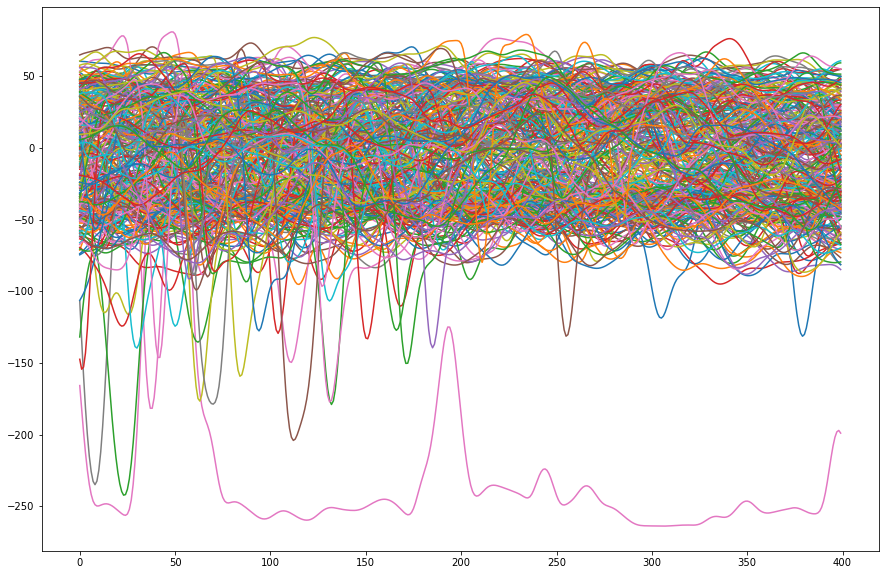

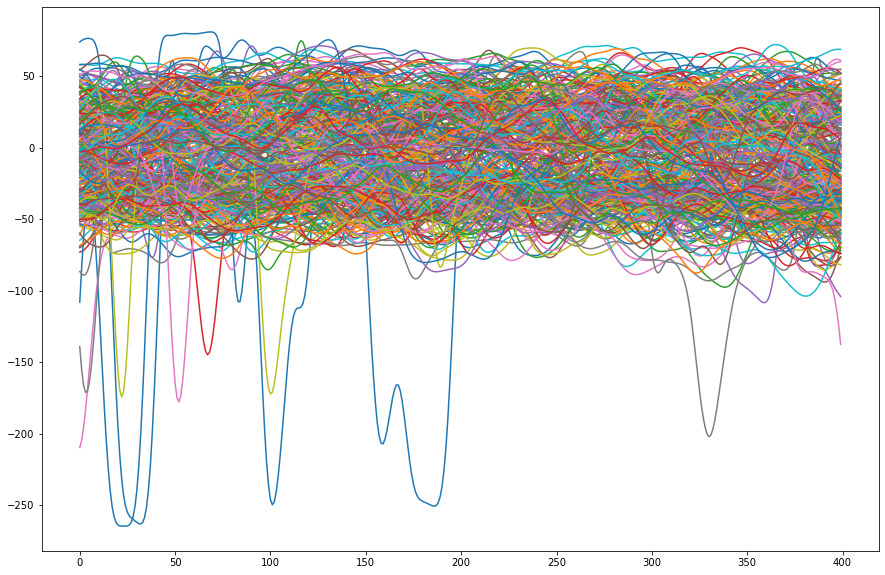

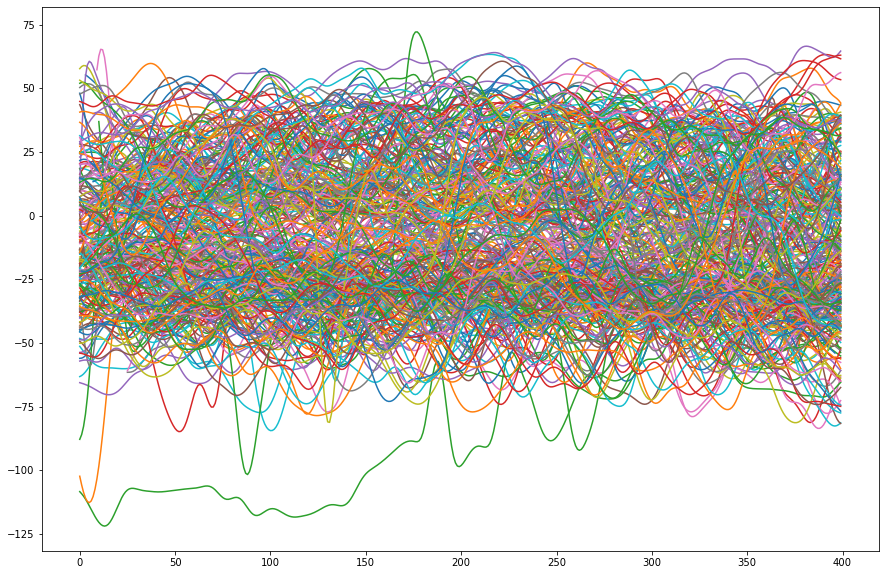

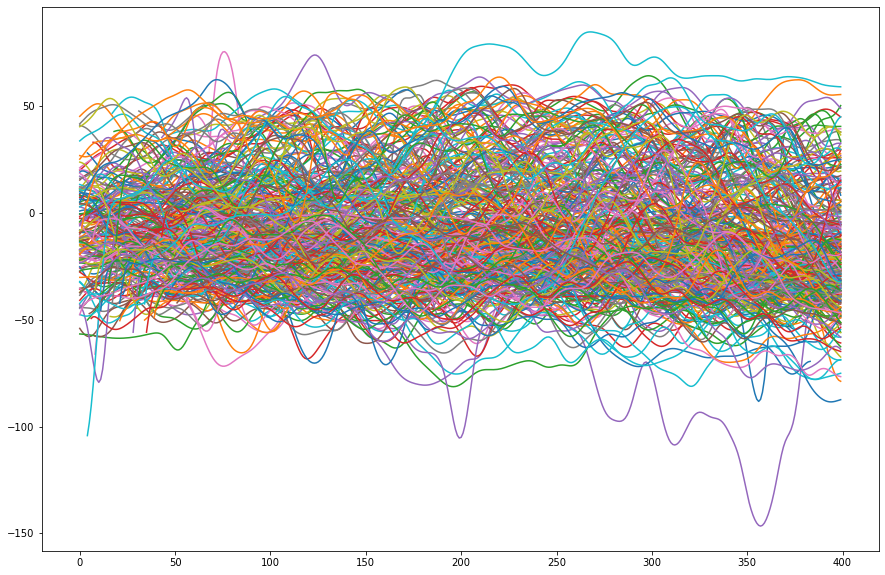

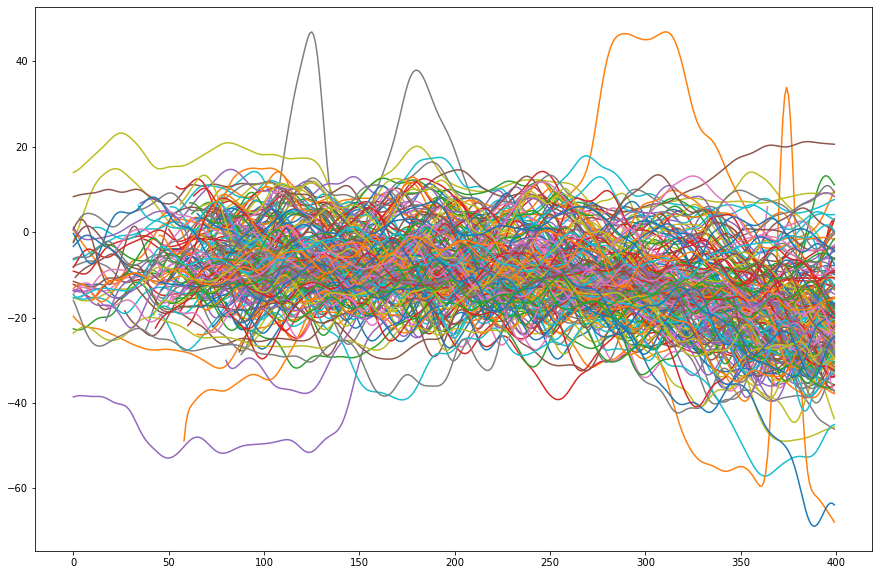

In [69]:
MouseID_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
search_key = ['4mm', '5mm', '8mm', '10mm', '45mm']
# 1 is TA topcam, thresh_1 is -200, thresh2 is 200, inter_1 is 100 inter_2 450
# 2 is centroidX, thresh_1 is 50, thresh2 is 500, inter_1 is 50 inter_2 450, center is 180
# 18 is BodyAxis, dict_no_pert, search_key, MouseID_key, value_idx, 110, 70, 100, 400, 90)
# 20 is BodyAxis, values (dict_no_pert, search_key, MouseID_key, value_idx, 110, 70, 100, 400, 90)
# 23 is cent tail base angle, (dict_no_pert, search_key, MouseID_key, value_idx, 50, -50, 100, 400, 0)
# 24 is nose cent, values (dict_no_pert, search_key, MouseID_key, value_idx,  195, 160, 80, 380, 180)
# 25 is  cent tail1 tail 2, (dict_no_pert, search_key, MouseID_key, value_idx, 250, 100, 150, 450, 180)
# 26 is tail1 nose angle, thresh_1 is 50, thresh2 is 500, inter_1 is 50 inter_2 450, center is 180
# 27 is nose tail angle, (dict_no_pert, search_key, MouseID_key, value_idx, 200, 160, 100, 400, 180)
# 28 is noce cent tail angle, (dict_no_pert, search_key, MouseID_key, value_idx, 210, 150, 80, 380, 180)
# 29 is Hip angle side cam, 140, 50, 100, 400, 90 remeber to uncomment funct %180
value_idx = 1
dict_ridge_to_sort = dict_ridge_all
dict_no_pert = extract_non_pert_trials(dict_ridge_to_sort, search_key, value_idx)
dict_mean, dict_std, dict_max = plot_extract_mean(dict_no_pert, search_key, MouseID_key, value_idx, \
                                                  10000, -10000, 100, 500, 0)

In [ ]:
dict_std

In [66]:
dict_mean

defaultdict(dict,
            {'4mm': [31.19502563980491,
              24.398930045920476,
              26.98302844924055,
              36.820516844078426,
              24.61301685676664,
              24.04940272738444,
              31.07240477046654,
              37.83806825096281,
              19.530462713464743,
              40.846017040029075,
              32.33263379852243,
              36.96455340739943,
              29.81563707561351,
              32.43766925325831,
              23.215060917347174],
             '5mm': [23.26145759012998,
              26.419814528568004,
              27.15560877481381,
              28.176183044915568,
              24.8745820053709,
              33.72032947363001,
              34.33400101932458,
              39.859031758098915,
              25.05531419156994,
              34.55475844504009,
              30.43667009606915,
              31.629733525942928,
              27.97066619368436,
              33.000090784990164,
 

In [67]:
#Save values into dict

data = dict_mean
import pandas as pd

(pd.DataFrame.from_dict(data=data, orient='index')
   .to_csv('dict_perc_time.csv', header=False))